# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pm4py as pm
import plotly.express as pe
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.visualization.graphs import visualizer as graphs_visualizer
import networkx as nx
from IPython.core.display import HTML
import pydotplus

# Importing test log

In [2]:
log = pd.read_csv("log.csv")

In [3]:
log.head()

,NHC,DATA,Atividade Agrupada,STAFF ID
0,2637.0,20/08/2019,Consulta Ortopedia,43523.0
1,2637.0,29/08/2019,Rx Anca,34240.0
2,2637.0,29/08/2019,Rx Bacia,34240.0
3,2637.0,07/09/2019,Consulta Ortopedia,31897.0
4,2637.0,16/09/2019,RM Bacia,34233.0


# Converting to XES and Renaming

In [3]:
log = log.rename(columns={"STAFF ID":"org:resource"})
log = pm.format_dataframe(log, case_id = "NHC", activity_key="Atividade Agrupada", timestamp_key="DATA")
log = log.drop(["NHC","DATA","Atividade Agrupada","@@index"], axis = 1)
log["org:resource"] = log["org:resource"].astype(str)

c:\Users\PMMCardoso\anaconda3\lib\site-packages\pm4py\utils.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
c:\Users\PMMCardoso\anaconda3\lib\site-packages\pm4py\utils.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[xes_constants.DEFAULT_NAME_KEY] = df[xes_constants.DEFAULT_NAME_KEY].astype("string")


In [70]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8894 entries, 0 to 8893
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   org:resource       8894 non-null   object             
 1   case:concept:name  8894 non-null   string             
 2   concept:name       8894 non-null   string             
 3   time:timestamp     8894 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1), string(2)
memory usage: 278.1+ KB


# EDA on the Event Log

In [5]:
log.head()

,org:resource,case:concept:name,concept:name,time:timestamp
0,532.0,100387160.0,Cirurgia Primária,2021-11-19 00:00:00+00:00
1,532.0,100387160.0,Internamento,2021-11-19 00:00:00+00:00
2,36867.0,100387160.0,Fisioterapia,2021-11-20 00:00:00+00:00
3,532.0,100387160.0,Consulta Ortopedia,2021-12-03 00:00:00+00:00
4,432.0,101152.0,Consulta Ortopedia,2020-08-31 00:00:00+00:00


## Number of activities per patient

In [6]:
n_activities = log.groupby("case:concept:name")["concept:name"].count()
pe.box(n_activities,
    title = "Number of activities by patient",
    width = 700,
    height = 400,
    template = "simple_white",
    orientation="h",
    labels = {"value" : "N Activities", "variable" : ""}
    )

## Distribution of activities

In [7]:
log3=log[["case:concept:name","concept:name"]]
gb=log3.value_counts().to_frame("counts").reset_index()
d_act=gb["concept:name"].value_counts().head(10).to_frame()
d_act["concept:name"]=d_act["concept:name"].apply(lambda x : (x*100)/log["case:concept:name"].nunique())
d_act["concept:name"]=d_act["concept:name"].round(decimals=1)
d_act

,concept:name
Internamento,98.6
Cirurgia Primária,96.6
Fisioterapia,92.0
Consulta Ortopedia,89.2
Rx Anca,84.1
Rx Bacia,70.8
Análises,52.2
Consulta Anestesia,44.5
Cirurgia Complementar,10.8
Infiltração,4.6


In [8]:
fig2=pe.bar(d_act,
    template="simple_white",
    width=700,
    height=400,
    title="Actividades mais comuns por doente",
    labels={"value":"%","index":""},
    color_discrete_sequence=["Teal"],
    )
fig2.update_layout(showlegend=False)

## Distribution of Traces

In [9]:
list_cases = log["case:concept:name"].unique()
list_cases

<StringArray>
['100387160.0',    '101152.0',    '102903.0',    '105589.0',    '105666.0',
 '106773224.0',    '107209.0',    '107438.0',    '107570.0',    '111301.0',
 ...
     '88725.0',     '90375.0',     '91192.0',     '92732.0',     '95240.0',
     '98201.0',     '98364.0',     '98516.0',     '98631.0',     '99504.0']
Length: 712, dtype: string

In [10]:
Traces = []
ids = []
for i in list_cases:
    a = log.loc[log["case:concept:name"] == "{}".format(i)].sort_values(["time:timestamp"])
    b = a["concept:name"].str.cat(sep=",")
    ids.append(i)
    Traces.append(b)
trace_db = pd.DataFrame({"ID":ids,"Trace":Traces})

trace_db = trace_db.Trace.value_counts().head(10).to_frame().reset_index()
trace_db.Trace = trace_db.Trace.apply(lambda x : (x*100)/log["case:concept:name"].nunique())
trace_db.Trace = trace_db.Trace.round(decimals=1)
trace_db



,index,Trace
0,"Cirurgia Primária,Internamento,Rx Anca,Fisiote...",2.5
1,"Cirurgia Primária,Internamento,Fisioterapia",1.4
2,"Consulta Ortopedia,Cirurgia Primária,Intername...",1.1
3,"Consulta Ortopedia,Cirurgia Primária,Intername...",1.0
4,"Consulta Ortopedia,Cirurgia Primária,Intername...",0.8
5,"Consulta Ortopedia,Análises,Cirurgia Primária,...",0.7
6,"Consulta Ortopedia,Análises,Análises,Cirurgia ...",0.7
7,"Consulta Ortopedia,Análises,Cirurgia Primária,...",0.7
8,"Rx Anca,Rx Bacia,Consulta Ortopedia,Cirurgia P...",0.7
9,"Rx Anca,Rx Bacia,Consulta Ortopedia,Cirurgia P...",0.6


In [11]:
fig4 = pe.bar(trace_db, x = "Trace", y = "index",
    orientation="h",
    width = 1000,
    height = 400,
    template="simple_white",
    labels={"index":"","Trace":"%"},
    color_discrete_sequence=["Teal"],
    text="Trace").update_yaxes(categoryorder="total ascending").update_xaxes(visible=False)
fig4.update_layout(yaxis=dict(tickfont=dict(size=8)))
fig4.update_traces(textposition="outside")


In [45]:
a = log.loc[log["case:concept:name"] == "91192.0"].sort_values(["time:timestamp"])
b = a["concept:name"].str.cat(sep=",")
b

'Consulta Anestesia,Cirurgia Primária,Fisioterapia,Internamento,Rx Anca,Fisioterapia,Rx Anca,Rx Anca,Rx Bacia,Consulta Ortopedia,Rx Anca,Rx Anca,Rx Bacia'

# Process Discovery

In [29]:
filtered_log = pm.filter_case_size(elog, 3, 30)

In [39]:
heu_net = pm.discover_heuristics_net(filtered_log, dependency_threshold=0.99, loop_two_threshold=0.99)

from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
parameters=hn_visualizer.Variants.PYDOTPLUS.value.Parameters
gviz=hn_visualizer.apply(heu_net,parameters={parameters.FORMAT:"png","bgcolor":"white"})
gviz


# Time and other analysis

## Duration of Traces

In [9]:
elog = pm.convert_to_event_log(log)

In [107]:
all_case_durations = pm.get_all_case_durations(log)
durations = pd.DataFrame(all_case_durations,columns=["durat"])
durations.durat = durations.durat.apply(lambda x : (((x/60)/60)/24))
durations


,durat
0,0.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
707,993.0
708,999.0
709,1016.0
710,1065.0


In [117]:
fig5=pe.histogram(durations,
    template="simple_white",
    width = 700,
    height = 400,
    labels={"value":"Nº de dias"},
    marginal="box")
fig5.update_layout(showlegend=False)

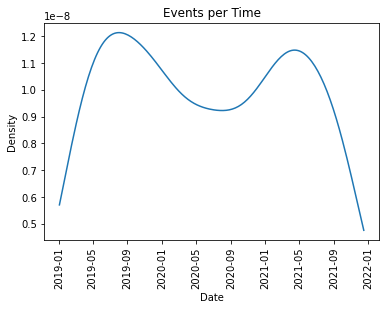

<Figure size 1440x720 with 0 Axes>

In [42]:
x, y = attributes_filter.get_kde_date_attribute(elog, attribute="time:timestamp")
gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
plt.figure(figsize = (20,10))
graphs_visualizer.view(gviz)

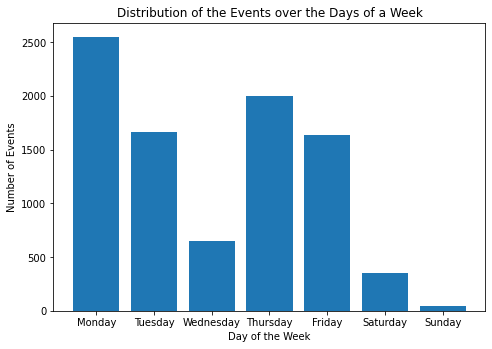

In [56]:
teste = pm.view_events_distribution_graph(elog, distr_type="days_week")
teste

## Social Network

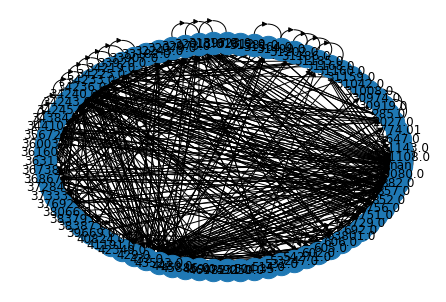

In [10]:
hw_values = pm.discover_handover_of_work_network(elog)
teste3 = pm.visualization.sna.visualizer.apply(hw_values)
pm.visualization.sna.visualizer.view(teste3)

In [6]:
from pyvis.network import Network
from pm4py.visualization.sna import visualizer as sna_visualizer
path = os.getcwd()
net = Network()
gviz2 = sna_visualizer.apply(hw_values, variant=sna_visualizer.Variants.PYVIS)
sna_visualizer.save(gviz2,f"{path}/html_files/pyvis_graph.html")

In [19]:
import shutil
import tempfile
from enum import Enum

import numpy as np

from pm4py.util import exec_utils, vis_utils


class Parameters(Enum):
    WEIGHT_THRESHOLD = "weight_threshold"


def get_temp_file_name(format):
    """
    Gets a temporary file name for the image

    Parameters
    ------------
    format
        Format of the target image
    """
    filename = tempfile.NamedTemporaryFile(suffix='.' + format)

    return filename.name


def apply(metric_values, parameters=None):
    """
    Perform SNA visualization starting from the Matrix Container object
    and the Resource-Resource matrix

    Parameters
    -------------
    metric_values
        Value of the metrics
    parameters
        Possible parameters of the algorithm, including:
            - Parameters.WEIGHT_THRESHOLD -> the weight threshold to use in displaying the graph

    Returns
    -------------
    temp_file_name
        Name of a temporary file where the visualization is placed
    """
    from pyvis.network import Network

    if parameters is None:
        parameters = {}

    weight_threshold = exec_utils.get_param_value(Parameters.WEIGHT_THRESHOLD, parameters, 0)
    directed = metric_values[2]

    temp_file_name = get_temp_file_name("html")

    rows, cols = np.where(metric_values[0] > weight_threshold)
    weights = list()

    for x in range(len(rows)):
        weights.append(metric_values[0][rows[x]][cols[x]])

    got_net = Network(height="750px", width="100%", bgcolor="white", font_color="#f5b642", directed=directed)
    # set the physics layout of the network
    got_net.barnes_hut()

    edge_data = zip(rows, cols, weights)

    for e in edge_data:
        src = metric_values[1][e[0]]  # convert ids to labels
        dst = metric_values[1][e[1]]
        w = e[2]

        # I have to add some options here, there is no parameter
        highlight = {'border': "#164bdb", 'background': "#16b7db"}
        # color = {'border': "#000000", 'background': "#123456"}
        got_net.add_node(src, src, title=src, labelHighlightBold=True, color={'highlight': highlight})
        got_net.add_node(dst, dst, title=dst, labelHighlightBold=True, color={'highlight': highlight})
        got_net.add_edge(src, dst, value=w, title=w)

    neighbor_map = got_net.get_adj_list()

    dict = got_net.get_edges()

    # add neighbor data to node hover data
    for node in got_net.nodes:
        counter = 0
        if directed:
            node["title"] = "<h3>" + node["title"] + " Output Links: </h3>"
        else:
            node["title"] = "<h3>" + node["title"] + " Links: </h3>"
        for neighbor in neighbor_map[node["id"]]:
            if (counter % 10 == 0):
                node["title"] += "<br>::: " + neighbor
            else:
                node["title"] += " ::: " + neighbor
            node["value"] = len(neighbor_map[node["id"]])
            counter += 1

    got_net.set_options("""
    var options = {
        "nodes": {
            "borderwidth" : 1,
            "borderwidthselected" : 2,
            "color": {
                "background" : "rgba(114,191,197,1)",
                "border" : "rgba(0,100,121,1)",
                "highlight" : {
                    "color" : "rgba(22,78,219,1)"
                }
            },
            "font": {
                "size": 70,
                "color" : "rgba(219,111,22,1)",
                "face" : "verdana"
            },
            "labelHighlightBold": true,
            "physics": true,
            "scaling": {
                "min": 10,
                "max": 30
            },
            "shape" : "ellipse",
            "shapeProperties": {
                "borderRadius": 6,
                "interpolation": true
            }
        },
        "edges": {
            "arrowStrikethrough": true,
            "color": {
                "color" : "rgba(114,191,197,1)",
                "inherit": true
            },
            "hoverWidth" : 1.5,
            "labelHighlightBold" : true,
            "physics" : true,
            "scaling": {
                "min": 1,
                "max": 15
            },
            "selectionWidth" : 1.5,
            "selfReferenceSize" : 20,
            "selfReference": {
                "size" : 20,
                "angle": 0.7853981633974483,
                "renderBehindTheNode" : true
            },
            "smooth": {
                "type" : "dynamic",
                "forceDirection": "none",
                "roundness" : 0.5
            },
            "width" : 1
        },
        "physics": {
            "barnesHut": {
                "gravitationalConstant": -80000,
                "springLenght" : 250,
                "springConstant" : 0.001
            },
        "minVelocity": 0.75
        }
    }
    """)
    

    got_net.write_html(temp_file_name)

    print([i for i in edge_data])
    print(neighbor_map)
    print(dict)

    return temp_file_name


def save(temp_file_name, dest_file, parameters=None):
    """
    Save the SNA visualization from a temporary file to a well-defined destination file

    Parameters
    -------------
    temp_file_name
        Temporary file name
    dest_file
        Destination file
    parameters
        Possible parameters of the algorithm
    """
    if parameters is None:
        parameters = {}

    shutil.copyfile(temp_file_name, dest_file)

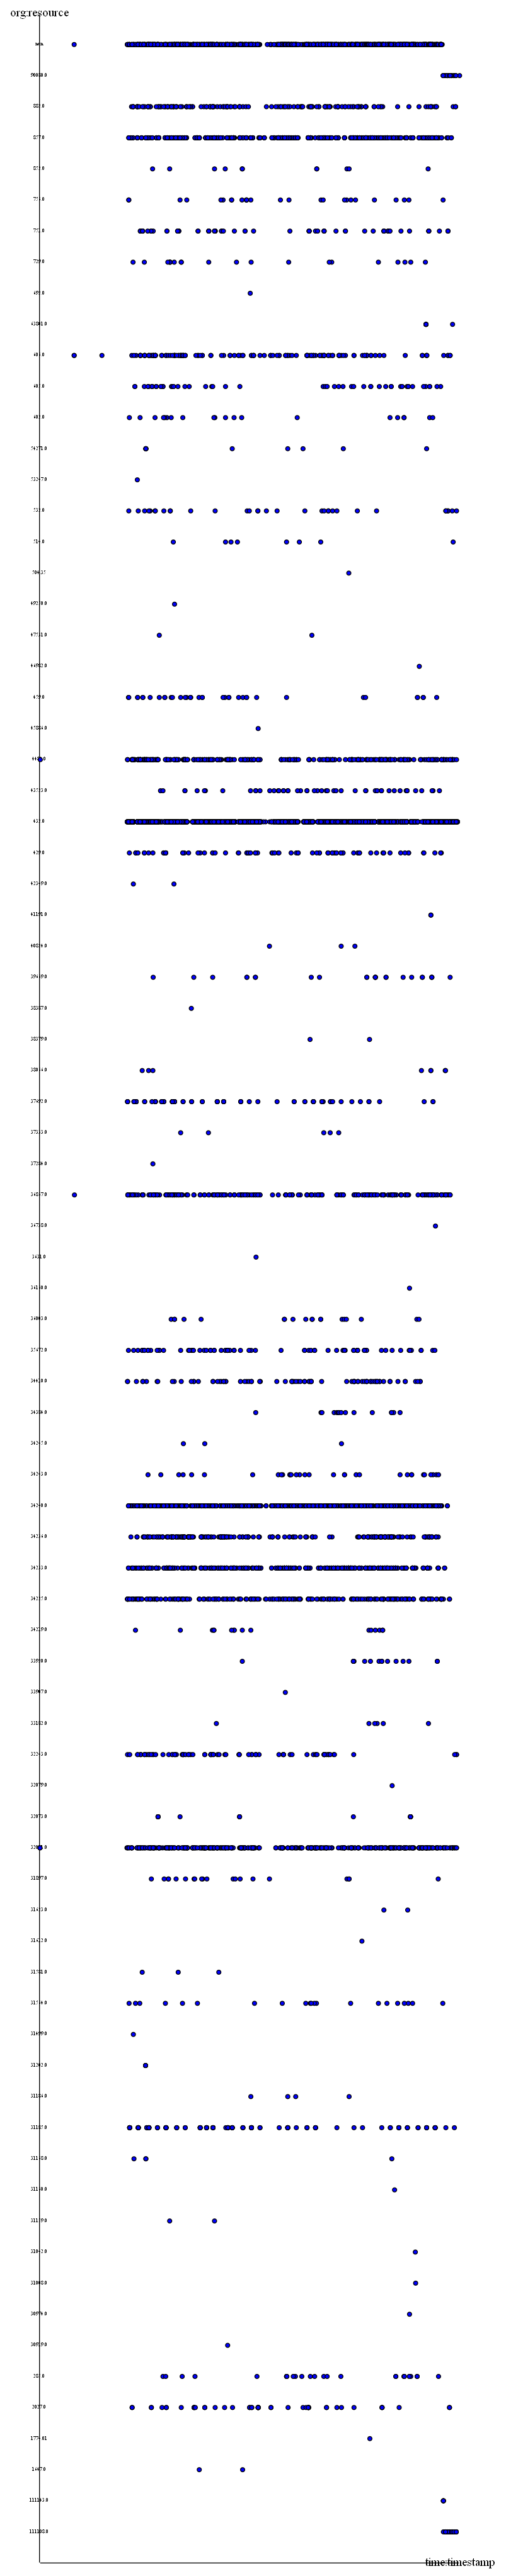

In [59]:
pm.view_dotted_chart(elog, format="png", attributes=["time:timestamp","org:resource"])

In [13]:
edge_data

NameError: name 'edge_data' is not defined

# Deploying into streamlit

In [66]:
%%writefile Home.py

import streamlit as st
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pm4py as pm
import os
from PIL import Image
import plotly.express as pe
import missingno as msn
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pyvis.network import Network
from pm4py.visualization.sna import visualizer as sna_visualizer
import streamlit.components.v1 as components
import graphviz
import pydotplus
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
import shutil
import tempfile
from enum import Enum
from pm4py.util import exec_utils, vis_utils

st.set_page_config(layout="wide")

def check_password():
    """Returns `True` if the user had the correct password."""

    def password_entered():
        """Checks whether a password entered by the user is correct."""
        if st.session_state["password"] == st.secrets["password"]:
            st.session_state["password_correct"] = True
            del st.session_state["password"]  # don't store password
        else:
            st.session_state["password_correct"] = False

    if "password_correct" not in st.session_state:
        # First run, show input for password.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        return False
    elif not st.session_state["password_correct"]:
        # Password not correct, show input + error.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        st.error("😕 Password incorrect")
        return False
    else:
        # Password correct.
        return True

if check_password() == True:
    st.header("Home Page")

Overwriting Home.py


# Page 1 - Log Analysis and discovery

In [64]:
%%writefile "pages/🔀_Log_Analysis_and_discovery.py"

# Import necessary packages

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pm4py as pm
import os
from PIL import Image
import plotly.express as pe
import missingno as msn
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pyvis.network import Network
from pm4py.visualization.sna import visualizer as sna_visualizer
import streamlit.components.v1 as components
import graphviz
import pydotplus
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
import shutil
import tempfile
from enum import Enum
from pm4py.util import exec_utils, vis_utils

#Page Layout and config

st.set_page_config(
     page_title="Log Analysis and Process Discovery",
     page_icon=":twisted_rightwards_arrows:",
     layout="wide")

# Password check

def check_password():
    """Returns `True` if the user had the correct password."""

    def password_entered():
        """Checks whether a password entered by the user is correct."""
        if st.session_state["password"] == st.secrets["password"]:
            st.session_state["password_correct"] = True
            del st.session_state["password"]  # don't store password
        else:
            st.session_state["password_correct"] = False

    if "password_correct" not in st.session_state:
        # First run, show input for password.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        return False
    elif not st.session_state["password_correct"]:
        # Password not correct, show input + error.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        st.error("😕 Password incorrect")
        return False
    else:
        # Password correct.
        return True

if check_password() == True:

    # App structure

    st.title("🔀Log Analysis and Discovery")
    st.markdown("Process discovery describes the data-based visualization of a process and is a part of process mining. A process model is usually generated automatically from the data found in process discovery (via event logs). This model is often displayed as a direct follower graph. The primary goals of process discovery are increased transparency and process knowledge.")

    # Log Import

    log_file_input = st.file_uploader("Upload the event log file", accept_multiple_files=False, type = [".xlsx",".csv",".xes"], help = "The event log should have the following structure: ID, Timestamp, Activity, Resource")

    # File type driven operations

    if st.button("Run"): 
        if (os.path.splitext(log_file_input.name)[1]) == ".csv":
            log = pd.read_csv(log_file_input)
            log = log.rename(columns={log.columns[3]:"org:resource"})
            log = pm.format_dataframe(log, case_id = log.columns[0], activity_key=log.columns[2], timestamp_key=log.columns[1])
            log = log[['org:resource', 'case:concept:name', 'concept:name', 'time:timestamp']]
            log["org:resource"] = log["org:resource"].astype(str)
            elog = pm.convert_to_event_log(log)
        elif (os.path.splitext(log_file_input.name)[1]) == ".xlsx":
            log = pd.read_excel(log_file_input)
            log = log.rename(columns={log.columns[3]:"org:resource"})
            log = pm.format_dataframe(log, case_id = log.columns[0], activity_key=log.columns[2], timestamp_key=log.columns[1])
            log = log[['org:resource', 'case:concept:name', 'concept:name', 'time:timestamp']]
            log["org:resource"] = log["org:resource"].astype(str)
            elog = pm.convert_to_event_log(log)
        else:
            bytes_data = log_file_input.read()
            with open(os.path.join("/tmp", log_file_input.name), "wb") as f:
                f.write(bytes_data)
            xes_file = f.name
            elog = pm.read_xes(xes_file)
        
        tab1,tab2,tab3,tab4,tab5 = st.tabs([" Event log information","Time and Performance Analysis","Activities Report","Process Discovery","Social Network"])
        # Tab 1 - Log File Info
        with tab1:
            st.header(":page_facing_up:" "Log File and structure")
            st.subheader("Basic Information")
            st.write("There are **{} patients** in this event log".format(log["case:concept:name"].nunique()))
            st.dataframe(log)
            st.subheader("Missing Data")
            md = msn.matrix(log)
            st.pyplot(md.figure)
        # Tab 2 - Time and Performance Analysis
        with tab2:
            #Gráfico 1 - Case Durations
            st.header(":clock2:" "Time and Performance Analysis")
            st.subheader("Duration of Traces")
            all_case_durations = pm.get_all_case_durations(elog)
            durations = pd.DataFrame(all_case_durations,columns=["durat"])
            durations.durat = durations.durat.apply(lambda x : (((x/60)/60)/24))
            fig5=pe.histogram(durations,
            template="simple_white",
            width = 900,
            height = 400,
            labels={"value":"Nº de dias"},
            marginal="box")
            fig5.update_layout(showlegend=False)
            st.plotly_chart(fig5)
            #Gráfico 2 - Log density over time
            st.subheader("Log Density over time")
            x, y = attributes_filter.get_kde_date_attribute(elog, attribute="time:timestamp")
            gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
            image = Image.open(gviz)
            st.image(image, width = 900)
            # Gráficos 3 - Days of the week
            st.subheader("Distribution of activities by resource trough time")
            path = os.getcwd()
            time_resource = pm.save_vis_dotted_chart(elog, attributes=["time:timestamp","org:resource"],file_path = f"{path}/time_resource.png")
            image2 = Image.open("time_resource.png")
            st.image(image2, width = 900)
        # Tab 3 - Activities Report
        with tab3:
            st.header(":bar_chart:" "Activities Report")
            #Gráfico 1 - N activities
            st.subheader("Number of activities by patient")
            n_activities = log.groupby("case:concept:name")["concept:name"].count()
            n_act_graph = pe.box(n_activities,
            width = 900,
            height = 400,
            template = "simple_white",
            orientation="h",
            labels = {"value" : "N Activities", "variable" : ""},
            color_discrete_sequence=["Teal"])
            st.plotly_chart(n_act_graph)
            #Gráfico 2 - Most common activities
            st.subheader("Top10 activities")
            log3=log[["case:concept:name","concept:name"]]
            gb=log3.value_counts().to_frame("counts").reset_index()
            d_act=gb["concept:name"].value_counts().head(10).to_frame()
            d_act["concept:name"]=d_act["concept:name"].apply(lambda x : (x*100)/log["case:concept:name"].nunique())
            d_act["concept:name"]=d_act["concept:name"].round(decimals=1)
            fig2=pe.bar(d_act,
            template="simple_white",
            width=900,
            height=400,
            labels={"value":"%","index":""},
            color_discrete_sequence=["Teal"])
            fig2.update_layout(showlegend=False)
            st.plotly_chart(fig2)
            #Gráfico 3 - Traces
            st.subheader("Most common traces")
            list_cases = log["case:concept:name"].unique()
            Traces = []
            ids = []
            for i in list_cases:
                a = log.loc[log["case:concept:name"] == "{}".format(i)].sort_values(["time:timestamp"])
                b = a["concept:name"].str.cat(sep=",")
                ids.append(i)
                Traces.append(b)
            trace_db = pd.DataFrame({"ID":ids,"Trace":Traces})
            trace_db = trace_db.Trace.value_counts().head(10).to_frame().reset_index()
            trace_db.Trace = trace_db.Trace.apply(lambda x : (x*100)/log["case:concept:name"].nunique())
            trace_db.Trace = trace_db.Trace.round(decimals=1)
            fig4 = pe.bar(trace_db, x = "Trace", y = "index",
            orientation="h",
            width = 1000,
            height = 400,
            template="simple_white",
            labels={"index":"","Trace":"%"},
            color_discrete_sequence=["Teal"],
            text="Trace").update_yaxes(categoryorder="total ascending").update_xaxes(visible=False)
            fig4.update_layout(yaxis=dict(tickfont=dict(size=8)))
            fig4.update_traces(textposition="outside")
            st.plotly_chart(fig4)

        # Tab 4 - Heuristic Discovery
        with tab4:
            st.subheader(":mag_right: Process Discovery")
            filtered_log = pm.filter_case_size(elog, 3, 30)
            heu_net = pm.discover_heuristics_net(filtered_log, dependency_threshold=0.99, loop_two_threshold=0.99)
            path = os.getcwd()
            graph = pm.save_vis_heuristics_net(heu_net,file_path = f"{path}/heunet.png")
            image = Image.open("heunet.png")
            st.image(image)
        #Tab 5 - Social Network
        with tab5:

            ### THIS SECTION USES ORIGINAL PM4PY VIS SCRIPT TO ALLOW CUSTOMIZING PYVIS NETWORK
            ## START

            class Parameters(Enum):
                WEIGHT_THRESHOLD = "weight_threshold"


            def get_temp_file_name(format):
                """
                Gets a temporary file name for the image

                Parameters
                ------------
                format
                    Format of the target image
                """
                filename = tempfile.NamedTemporaryFile(suffix='.' + format)

                return filename.name


            def apply(metric_values, parameters=None):
                """
                Perform SNA visualization starting from the Matrix Container object
                and the Resource-Resource matrix

                Parameters
                -------------
                metric_values
                    Value of the metrics
                parameters
                    Possible parameters of the algorithm, including:
                        - Parameters.WEIGHT_THRESHOLD -> the weight threshold to use in displaying the graph

                Returns
                -------------
                temp_file_name
                    Name of a temporary file where the visualization is placed
                """
                from pyvis.network import Network

                if parameters is None:
                    parameters = {}

                weight_threshold = exec_utils.get_param_value(Parameters.WEIGHT_THRESHOLD, parameters, 0)
                directed = metric_values[2]

                temp_file_name = get_temp_file_name("html")

                rows, cols = np.where(metric_values[0] > weight_threshold)
                weights = list()

                for x in range(len(rows)):
                    weights.append(metric_values[0][rows[x]][cols[x]])

                got_net = Network(height="750px", width="120%", bgcolor="white", font_color="#f5b642", directed=directed)
                # set the physics layout of the network
                got_net.barnes_hut()

                edge_data = zip(rows, cols, weights)

                for e in edge_data:
                    src = metric_values[1][e[0]]  # convert ids to labels
                    dst = metric_values[1][e[1]]
                    w = e[2]

                    # I have to add some options here, there is no parameter
                    highlight = {'border': "#164bdb", 'background': "#16b7db"}
                    # color = {'border': "#000000", 'background': "#123456"}
                    got_net.add_node(src, src, title=src, labelHighlightBold=True, color={'highlight': highlight})
                    got_net.add_node(dst, dst, title=dst, labelHighlightBold=True, color={'highlight': highlight})
                    got_net.add_edge(src, dst, value=w, title=w)

                neighbor_map = got_net.get_adj_list()

                dict = got_net.get_edges()

                # add neighbor data to node hover data
                for node in got_net.nodes:
                    counter = 0
                    if directed:
                        node["title"] = "<h3>" + node["title"] + " Output Links: </h3>"
                    else:
                        node["title"] = "<h3>" + node["title"] + " Links: </h3>"
                    for neighbor in neighbor_map[node["id"]]:
                        if (counter % 10 == 0):
                            node["title"] += "<br>::: " + neighbor
                        else:
                            node["title"] += " ::: " + neighbor
                        node["value"] = len(neighbor_map[node["id"]])
                        counter += 1

                got_net.set_options("""
                var options = {
                    "nodes": {
                        "borderwidth" : 1,
                        "borderwidthselected" : 2,
                        "color": {
                            "background" : "rgba(114,191,197,1)",
                            "border" : "rgba(0,100,121,1)",
                            "highlight" : {
                                "color" : "rgba(22,78,219,1)"
                            }
                        },
                        "font": {
                            "size": 70,
                            "color" : "rgba(219,111,22,1)",
                            "face" : "verdana"
                        },
                        "labelHighlightBold": true,
                        "physics": true,
                        "scaling": {
                            "min": 10,
                            "max": 30
                        },
                        "shape" : "ellipse",
                        "shapeProperties": {
                            "borderRadius": 6,
                            "interpolation": true
                        }
                    },
                    "edges": {
                        "arrowStrikethrough": true,
                        "color": {
                            "color" : "rgba(114,191,197,1)",
                            "inherit": true
                        },
                        "hoverWidth" : 1.5,
                        "labelHighlightBold" : true,
                        "physics" : true,
                        "scaling": {
                            "min": 1,
                            "max": 15
                        },
                        "selectionWidth" : 1.5,
                        "selfReferenceSize" : 20,
                        "selfReference": {
                            "size" : 20,
                            "angle": 0.7853981633974483,
                            "renderBehindTheNode" : true
                        },
                        "smooth": {
                            "type" : "dynamic",
                            "forceDirection": "none",
                            "roundness" : 0.5
                        },
                        "width" : 1
                    },
                    "physics": {
                        "barnesHut": {
                            "gravitationalConstant": -80000,
                            "springLenght" : 250,
                            "springConstant" : 0.001
                        },
                    "minVelocity": 0.75
                    }
                }
                """)
                

                got_net.write_html(temp_file_name)
                

                return temp_file_name
            
            def save(temp_file_name, dest_file, parameters=None):

                if parameters is None:
                    parameters = {}

                shutil.copyfile(temp_file_name, dest_file)

            ## END

            st.subheader(":male-doctor:""Social Network")
            hw_values = pm.discover_handover_of_work_network(elog)
            gviz2 = apply(hw_values)
            path = os.getcwd()
            save(gviz2,f"{path}/sna.html")
            HtmlFile = open(f"{path}/sna.html")
            components.html(HtmlFile.read(), width = 1200, height = 800)
    



Overwriting pages/🔀_Log_Analysis_and_discovery.py


## Page 2 - Conformance Checking

In [50]:
%%writefile "pages/✅_Conformance_Checking.py"

# Basic Packages 

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pm4py as pm
import os
import plotly.express as pe
import lxml

# Page Config

st.set_page_config(
     page_title="Conformance Analysis",
     page_icon=":heavy_check_mark:",
     layout="wide")

# Password check

def check_password():
    """Returns `True` if the user had the correct password."""

    def password_entered():
        """Checks whether a password entered by the user is correct."""
        if st.session_state["password"] == st.secrets["password"]:
            st.session_state["password_correct"] = True
            del st.session_state["password"]  # don't store password
        else:
            st.session_state["password_correct"] = False

    if "password_correct" not in st.session_state:
        # First run, show input for password.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        return False
    elif not st.session_state["password_correct"]:
        # Password not correct, show input + error.
        st.text_input(
            "Password", type="password", on_change=password_entered, key="password"
        )
        st.error("😕 Password incorrect")
        return False
    else:
        # Password correct.
        return True

if check_password() == True:


    # Title and introduction

    st.title("✅ Conformance Checking")

    st.markdown("Conformance checking is a technique used to compare event logs or an actual process with the existing reference model, or target model, for that process. This technique determines whether the actual process corresponds to the target process. Conformance checking is a Process mining method used to check compliance.")
    
    #Upload Log File

    log_file_input = st.file_uploader("Upload the event log file", accept_multiple_files=False, type = [".xlsx",".csv",".xes"], help = "The event log should have the following structure: ID, Timestamp, Activity, Resource")

    # Upload BPMN

    bpmn_file_input = st.file_uploader("Upload the BPMN file", accept_multiple_files=False, type = [".bpmn"], help = "The designed process should be uploaded in a .bpmn file type. You case a free process modeler like bizagi")

    # File type driven operation

    if st.button("Run"):
        if (os.path.splitext(log_file_input.name)[1]) == ".csv":
            log = pd.read_csv(log_file_input)
            log = log.rename(columns={log.columns[3]:"org:resource"})
            log = pm.format_dataframe(log, case_id = log.columns[0], activity_key=log.columns[2], timestamp_key=log.columns[1])
            log = log[['org:resource', 'case:concept:name', 'concept:name', 'time:timestamp']]
            log["org:resource"] = log["org:resource"].astype(str)
            elog = pm.convert_to_event_log(log)
        elif (os.path.splitext(log_file_input.name)[1]) == ".xlsx":
            log = pd.read_excel(log_file_input)
            log = log.rename(columns={log.columns[3]:"org:resource"})
            log = pm.format_dataframe(log, case_id = log.columns[0], activity_key=log.columns[2], timestamp_key=log.columns[1])
            log = log[['org:resource', 'case:concept:name', 'concept:name', 'time:timestamp']]
            log["org:resource"] = log["org:resource"].astype(str)
            elog = pm.convert_to_event_log(log)
        else:
            bytes_data = log_file_input.read()
            with open(os.path.join("/tmp", log_file_input.name), "wb") as f:
                f.write(bytes_data)
            xes_file = f.name
            elog = pm.read_xes(xes_file)
           
        # Read BPMN and transform to petrinet

        bpmn_graph = pm.read_bpmn(bpmn_file_input)
        net, im, fm = pm.convert_to_petri_net(bpmn_graph)
        tab1,tab2 = st.tabs(["Token Replay Method","Alignments Method"])

        # Token Replay Method
        with tab1:
            replayed_traces = pm.conformance_diagnostics_token_based_replay(elog, net, im, fm)
            list_tf = []
            for i in range(len(replayed_traces)):
                trace_sel = replayed_traces[i]
                tf_t = trace_sel.get("trace_fitness")
                list_tf.append(tf_t)
            st.header("Token Replay Method")
            st.markdown("Token-based replay technique is a conformance checking algorithm that checks how well a process conforms with its model by replaying each trace on the model.Using the four counters produced tokens, consumed tokens, missing tokens, and remaining tokens, it records the situations where a transition is forced to fire and the remaining tokens after the replay ends. Based on the count at each counter, we can compute the fitness value between the trace and the model.")
            st.subheader("The trace fitness value is **{:.2f}**".format(np.mean(list_tf)))
            tf_g1=pe.histogram(list_tf,
            template="simple_white",
            width = 900,
            height = 400,
            labels={"variable":"Trace Fitness"},
            color_discrete_sequence=["teal"],
            marginal="box").update_xaxes(visible=False)
            tf_g1.update_layout(showlegend=False)
            st.plotly_chart(tf_g1)

        #Alignment Method
        
        with tab2:
            aligned_traces = pm.conformance_diagnostics_alignments(elog,net,im,fm)
            list_tf2 = []
            for i in range(len(aligned_traces)):
                trace_sel2 = aligned_traces[i]
                tf_t2 = trace_sel2.get("fitness")
                list_tf2.append(tf_t2)
            st.header("Alignment method")
            st.markdown("Alignments is a technique, which performs an exhaustive search to find out the optimal alignment between the observed trace and the process model. Hence, it is guaranteed to return the closest model run in comparison to the trace.")
            st.subheader("The trace fitness value is **{:.2f}**".format(np.mean(list_tf2)))
            tf_g2=pe.histogram(list_tf2,
            template="simple_white",
            width = 900,
            height = 400,
            labels={"variable":"Trace Fitness"},
            color_discrete_sequence=["teal"],
            marginal="box").update_xaxes(visible=False)
            tf_g2.update_layout(showlegend=False)
            st.plotly_chart(tf_g2)

    

Overwriting pages/✅_Conformance_Checking.py


In [32]:
bpmn_graph = pm.read_bpmn("Diagram 1.bpmn")
net, im, fm = pm.convert_to_petri_net(bpmn_graph)

In [8]:
replayed_traces = pm.conformance_diagnostics_token_based_replay(elog, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/573 [00:00<?, ?it/s]

In [9]:
list_tf = []
for i in range(len(replayed_traces)):
    trace_sel = replayed_traces[i]
    tf_t = trace_sel.get("trace_fitness")
    list_tf.append(tf_t)

print("The trace fitness is {}".format(np.mean(list_tf)))


The trace fitness is 0.36205191911402873


In [14]:
aligned_traces = pm.conformance_diagnostics_alignments(elog,net,im,fm)

aligning log, completed variants ::   0%|          | 0/573 [00:00<?, ?it/s]

In [16]:
list_tf = []
for i in range(len(aligned_traces)):
    trace_sel = aligned_traces[i]
    tf_t = trace_sel.get("fitness")
    list_tf.append(tf_t)

print("The trace fitness is {}".format(np.mean(list_tf)))

The trace fitness is 0.42194506447763647


In [24]:
tf_g1=pe.histogram(list_tf,
    template="simple_white",
    width = 900,
    height = 400,
    labels={"variable":"Trace Fitness"},
    color_discrete_sequence=["teal"],
    marginal="box").update_xaxes(visible=False)
tf_g1.update_layout(showlegend=False)

In [33]:

from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(elog, net,
                                                                                              im,
                                                                                              fm,
                                                                                              parameters=parameters_tbr)

replaying log with TBR, completed variants ::   0%|          | 0/706 [00:00<?, ?it/s]

In [34]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(elog, trans_fitness)
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])
                                

(Id_5a7f9de2-145c-46e2-aaac-e36f5a8e1f79, 'Cirurgia Primária') {'n_fit': 6, 'n_underfed': 682, 'fit_median_time': 86400.0, 'underfed_median_time': 18748800.0, 'relative_throughput': 217.0}
(Id_312fb7ff-8c30-413a-8564-5cca14f90299, 'Fisioterapia') {'n_fit': 346, 'n_underfed': 309, 'fit_median_time': 19008000.0, 'underfed_median_time': 21427200.0, 'relative_throughput': 1.1272727272727272}
(Id_f54609a6-3227-4ef8-9670-9edee5400821, 'Consulta Anestesia') {'n_fit': 2, 'n_underfed': 315, 'fit_median_time': 67132800.0, 'underfed_median_time': 34732800.0, 'relative_throughput': 0.5173745173745173}
(Id_ca5058dd-b0dc-46cf-a78e-c61b1f79dcef, 'Rx Anca') {'n_fit': 246, 'n_underfed': 353, 'fit_median_time': 8985600.0, 'underfed_median_time': 41817600.0, 'relative_throughput': 4.653846153846154}
(Id_617dc8bd-e379-45e9-b2af-e00f7f3c56a9, 'Internamento') {'n_fit': 605, 'n_underfed': 97, 'fit_median_time': 14169600.0, 'underfed_median_time': 44755200.0, 'relative_throughput': 3.158536585365854}
(Id_1107

In [35]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(elog, unwanted_activities)
for act in act_diagnostics:
    print(act, act_diagnostics[act])

Consulta Nutrição {'n_containing': 6, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 53352000.0, 'relative_throughput': 4.410714285714286}
Cirurgia Complementar {'n_containing': 77, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 56246400.0, 'relative_throughput': 4.65}
Consulta Fisiatria {'n_containing': 9, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 68515200.0, 'relative_throughput': 5.664285714285715}
Rx Apoio {'n_containing': 11, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 8294400.0, 'relative_throughput': 0.6857142857142857}
Infiltração {'n_containing': 33, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 58406400.0, 'relative_throughput': 4.828571428571428}
Rx Fémur {'n_containing': 5, 'n_fit': 547, 'fit_median_time': 12096000.0, 'containing_median_time': 69206400.0, 'relative_throughput': 5.7214285714285715}
Consulta URG {'n_containing': 9, 'n_fit': 547, 'fi

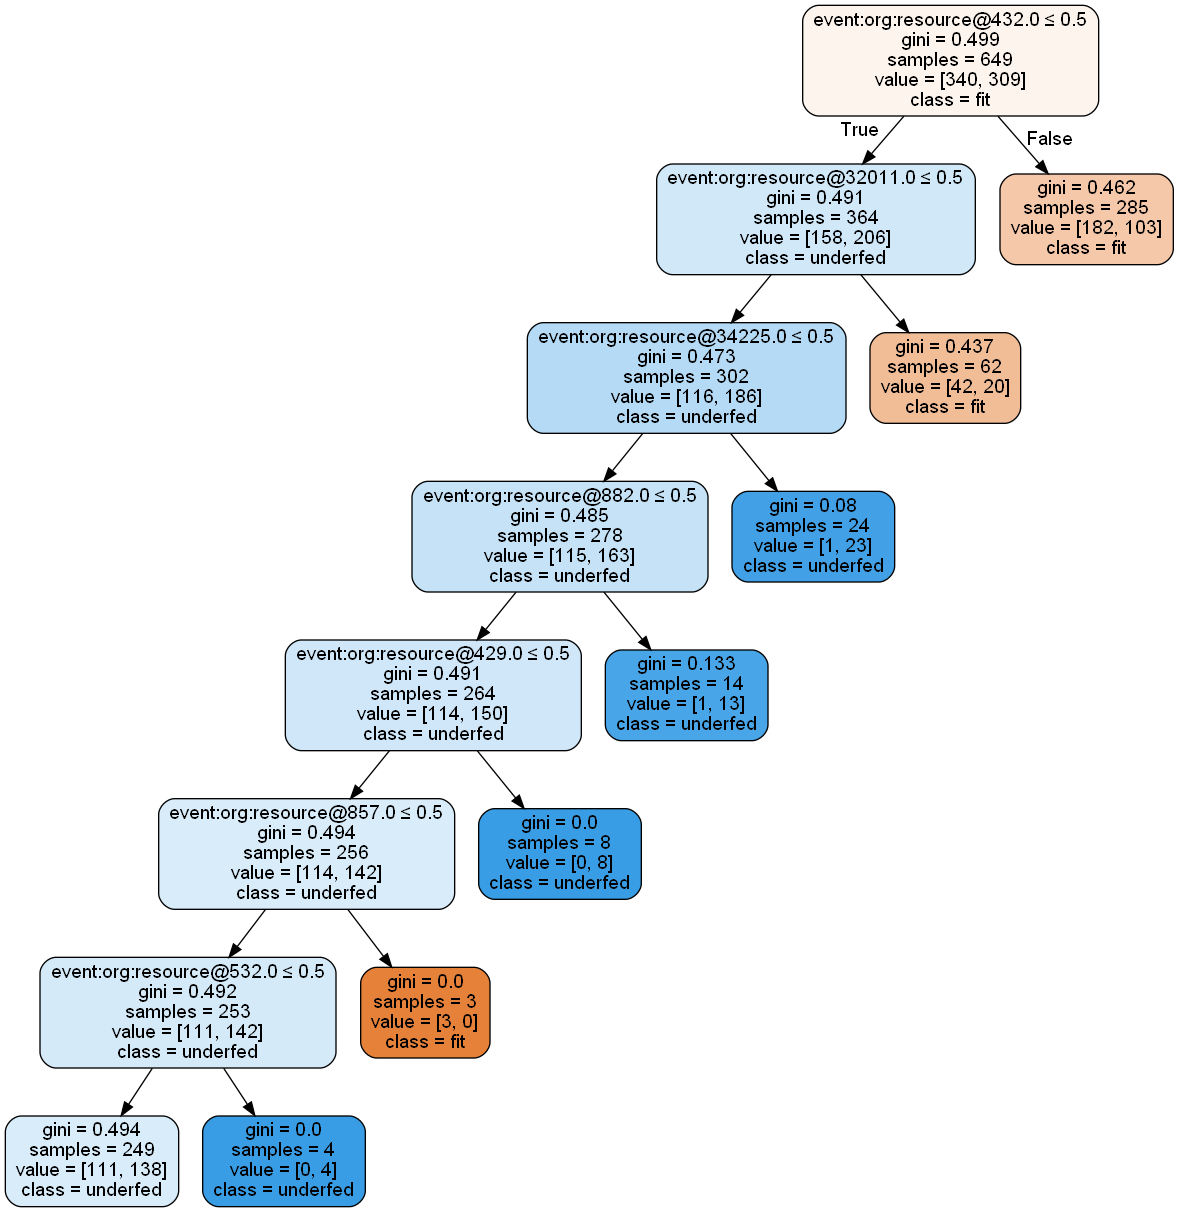

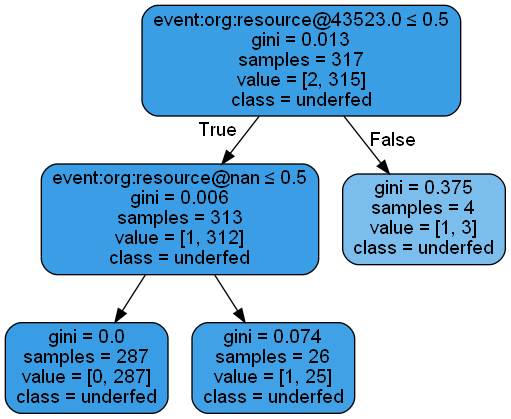

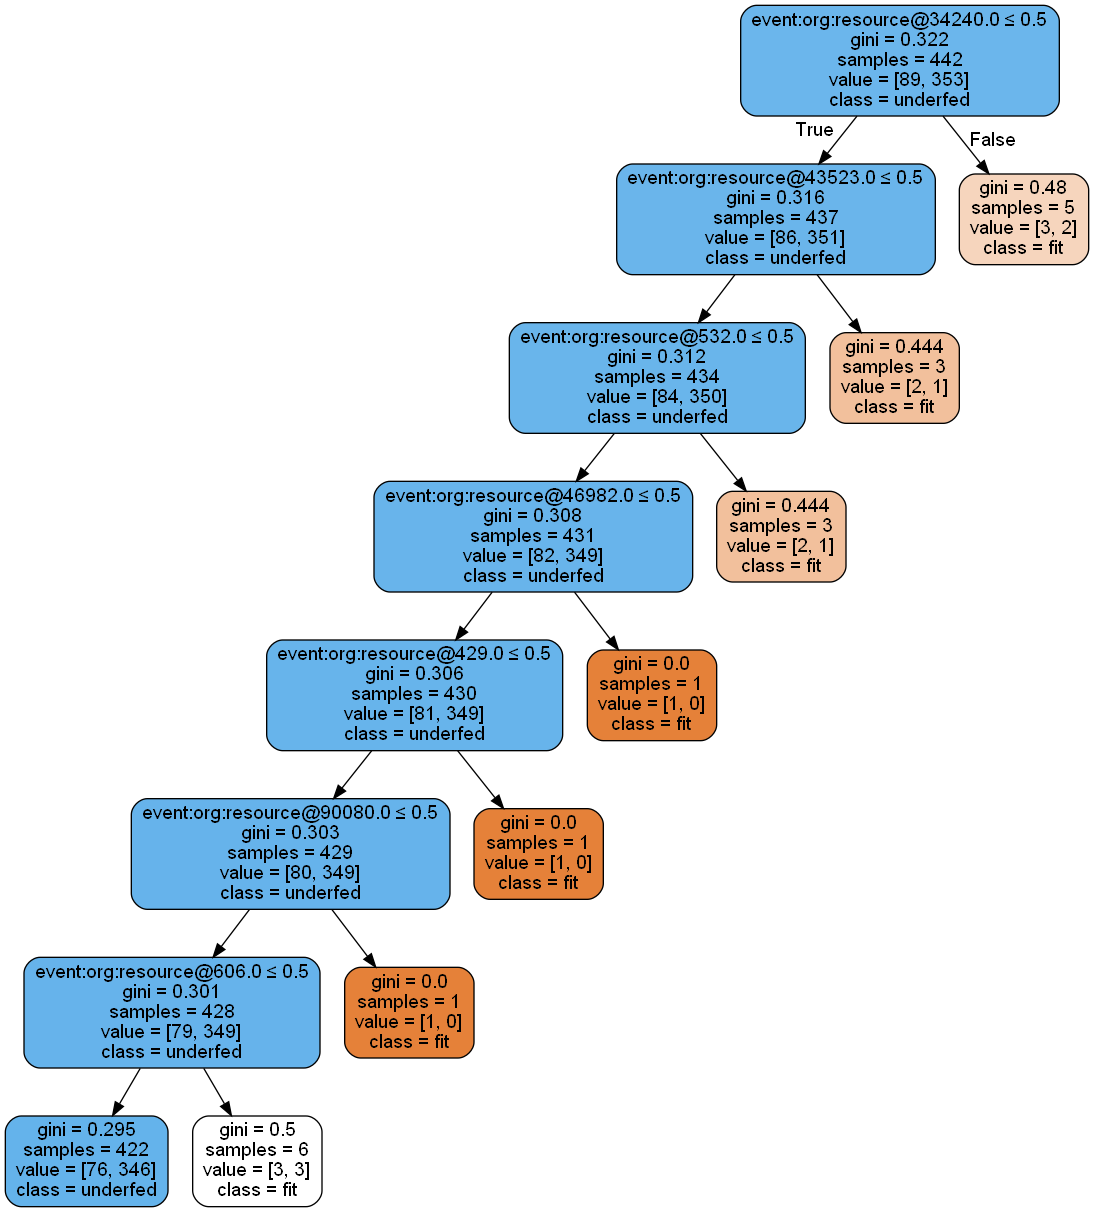

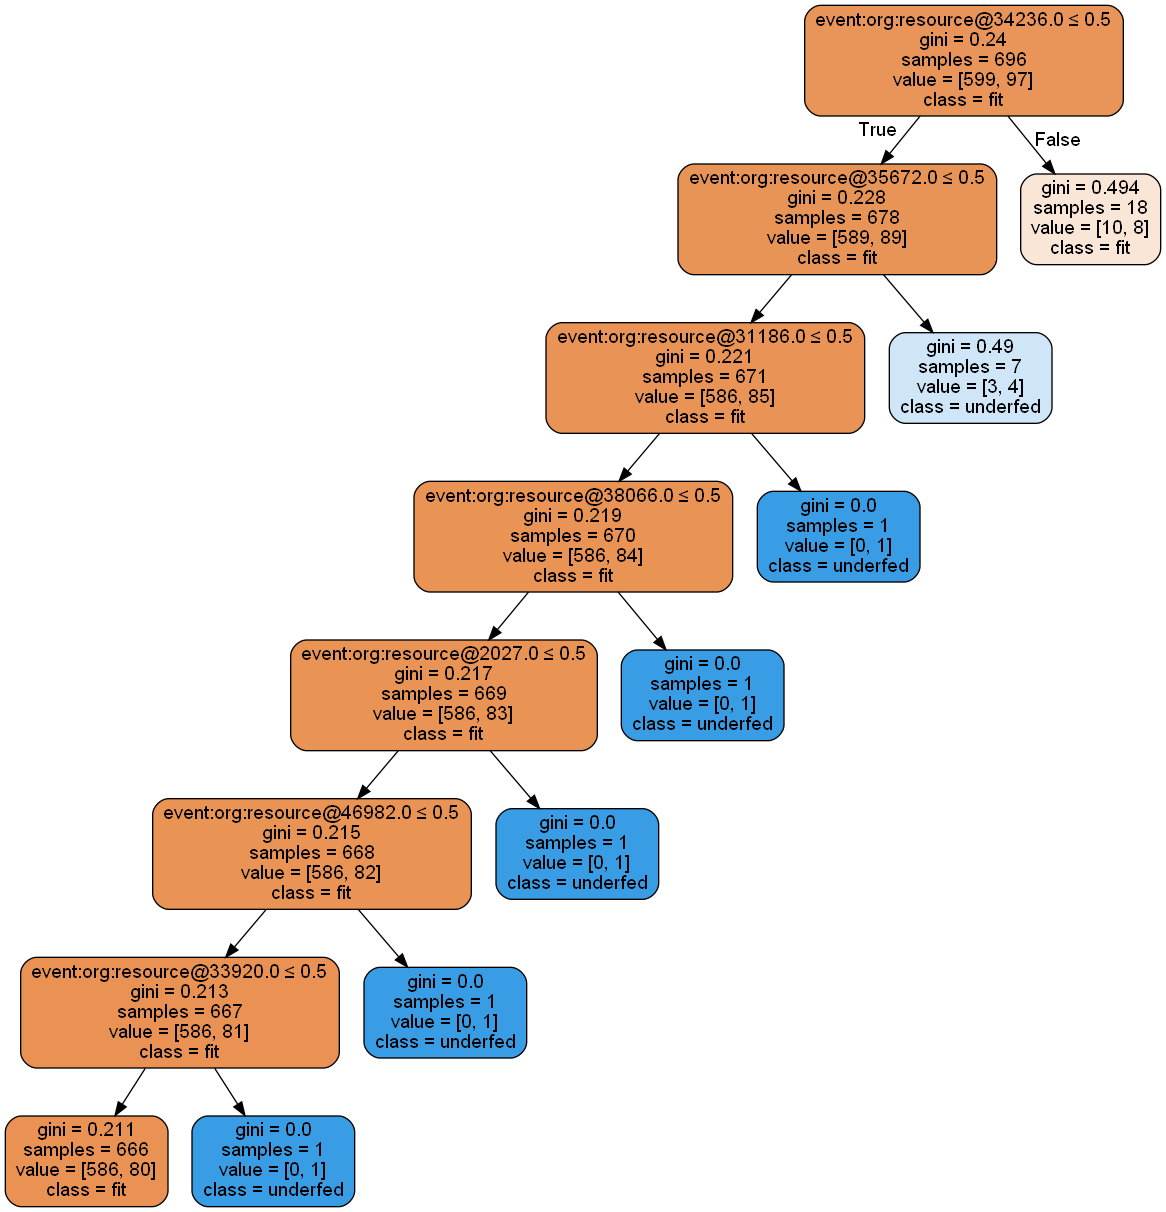

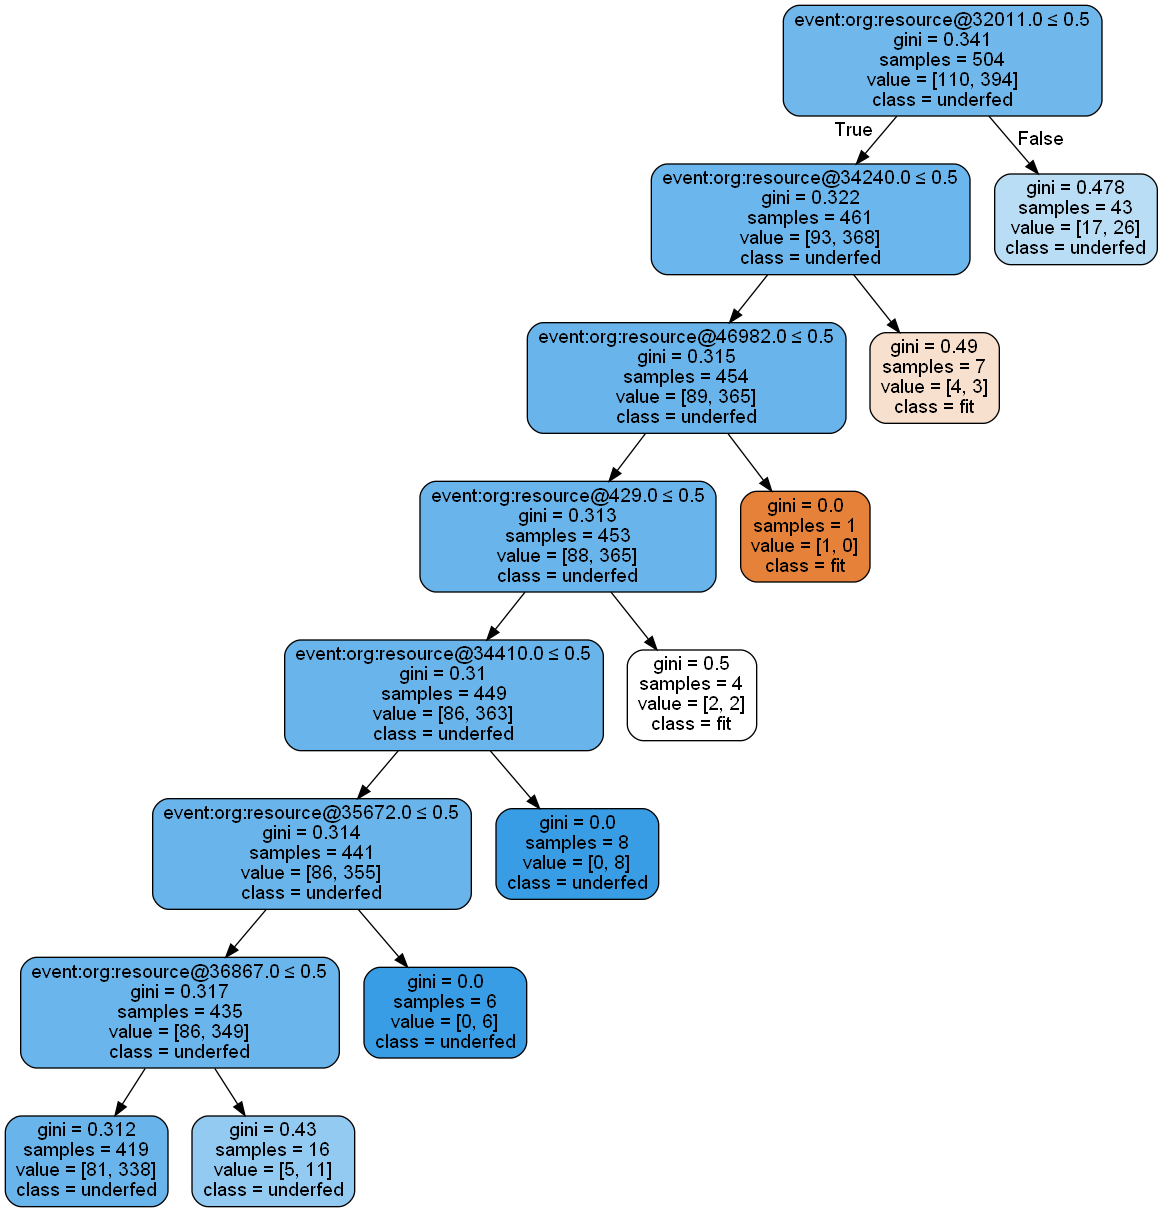

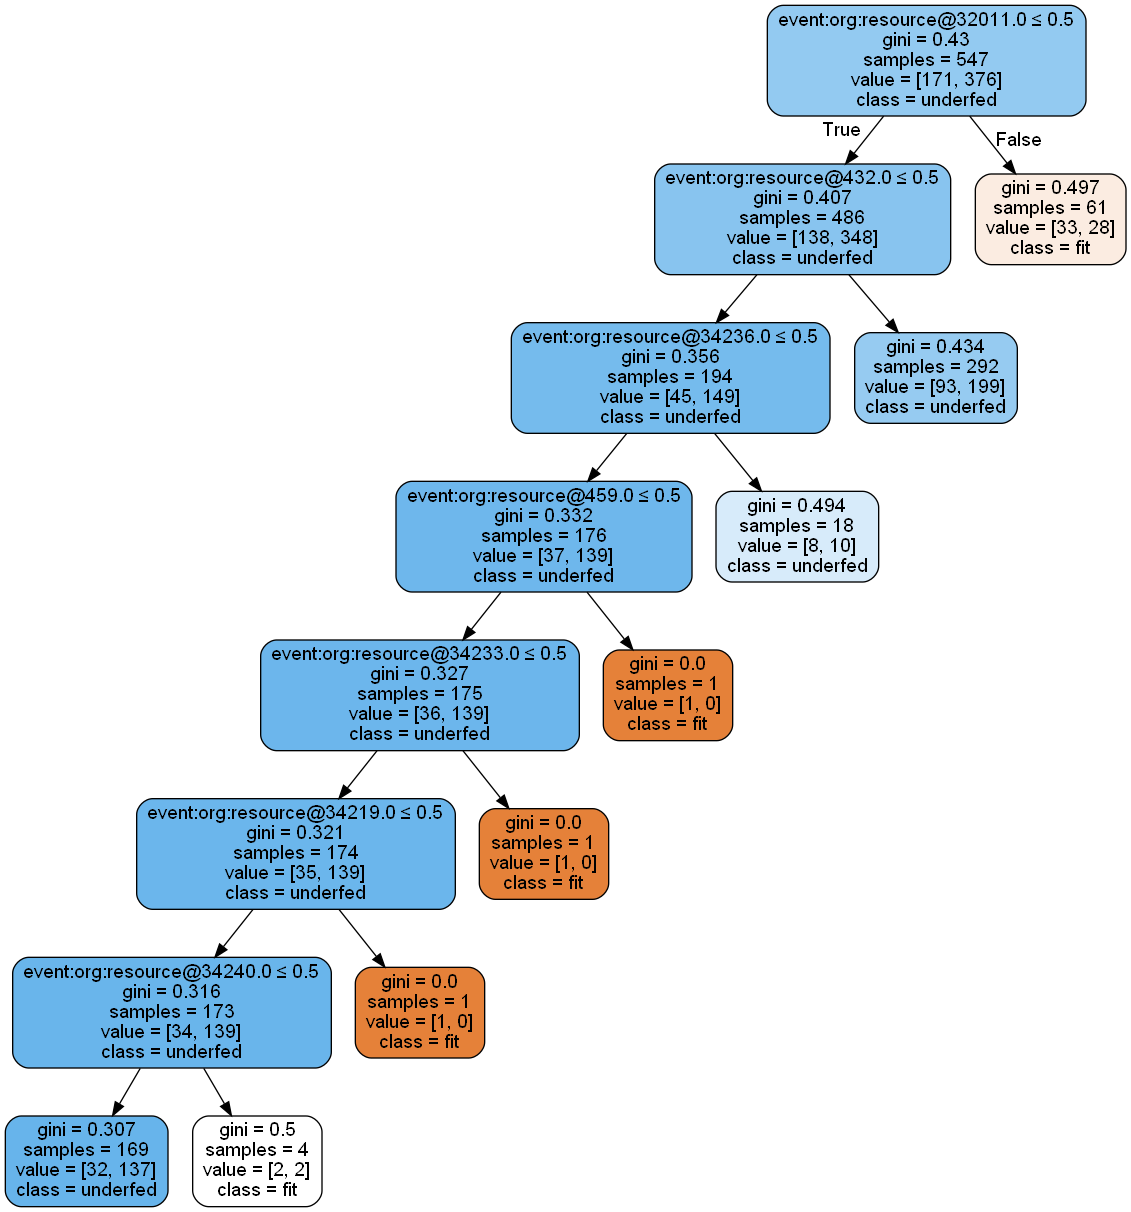

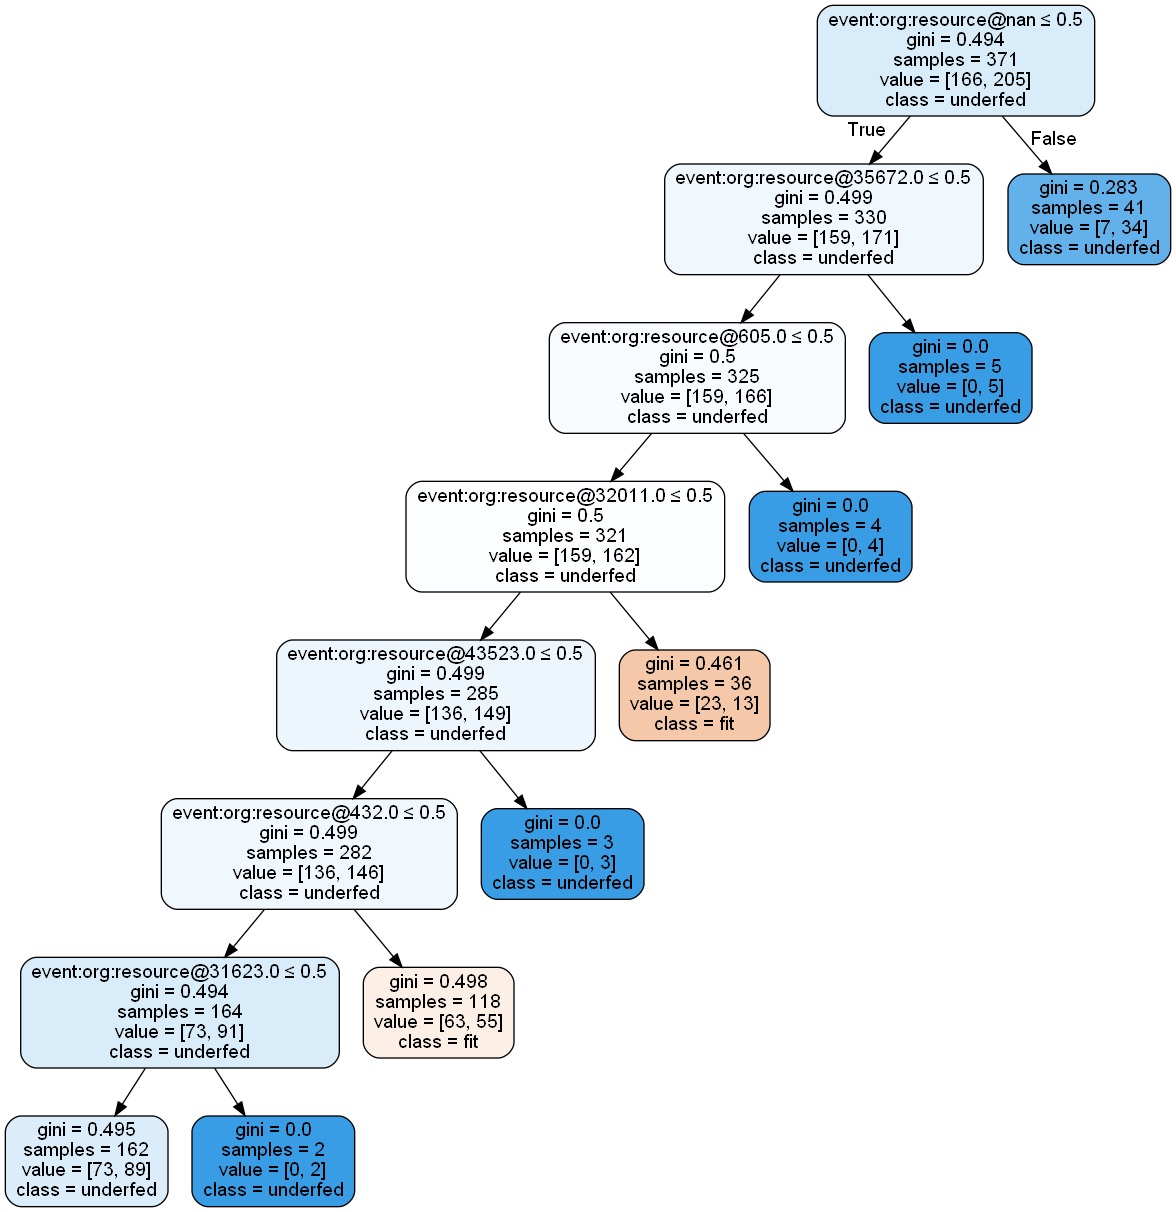

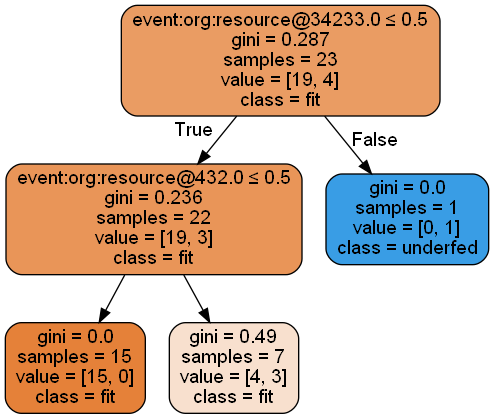

In [36]:
string_attributes = ["org:resource"]
numeric_attributes = []
parameters = {"string_attributes": string_attributes, "numeric_attributes": numeric_attributes}

from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
trans_root_cause = root_cause_analysis.diagnose_from_trans_fitness(elog, trans_fitness, parameters=parameters)

from pm4py.visualization.decisiontree import visualizer as dt_vis
for trans in trans_root_cause:
    clf = trans_root_cause[trans]["clf"]
    feature_names = trans_root_cause[trans]["feature_names"]
    classes = trans_root_cause[trans]["classes"]
    # visualization could be called
    gviz = dt_vis.apply(clf, feature_names, classes)
    dt_vis.view(gviz)

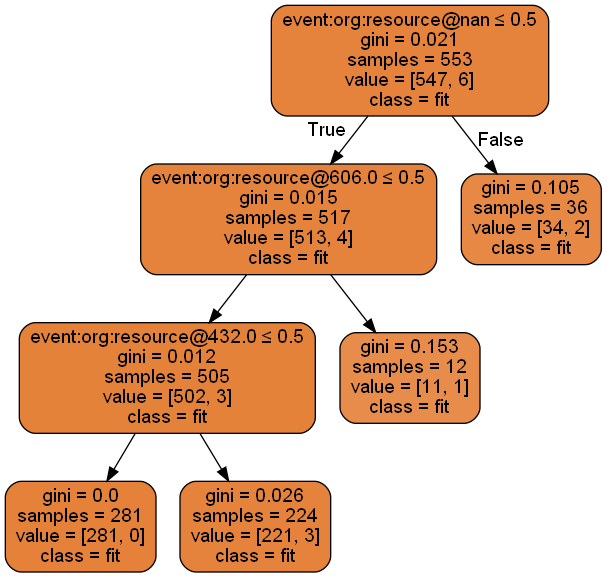

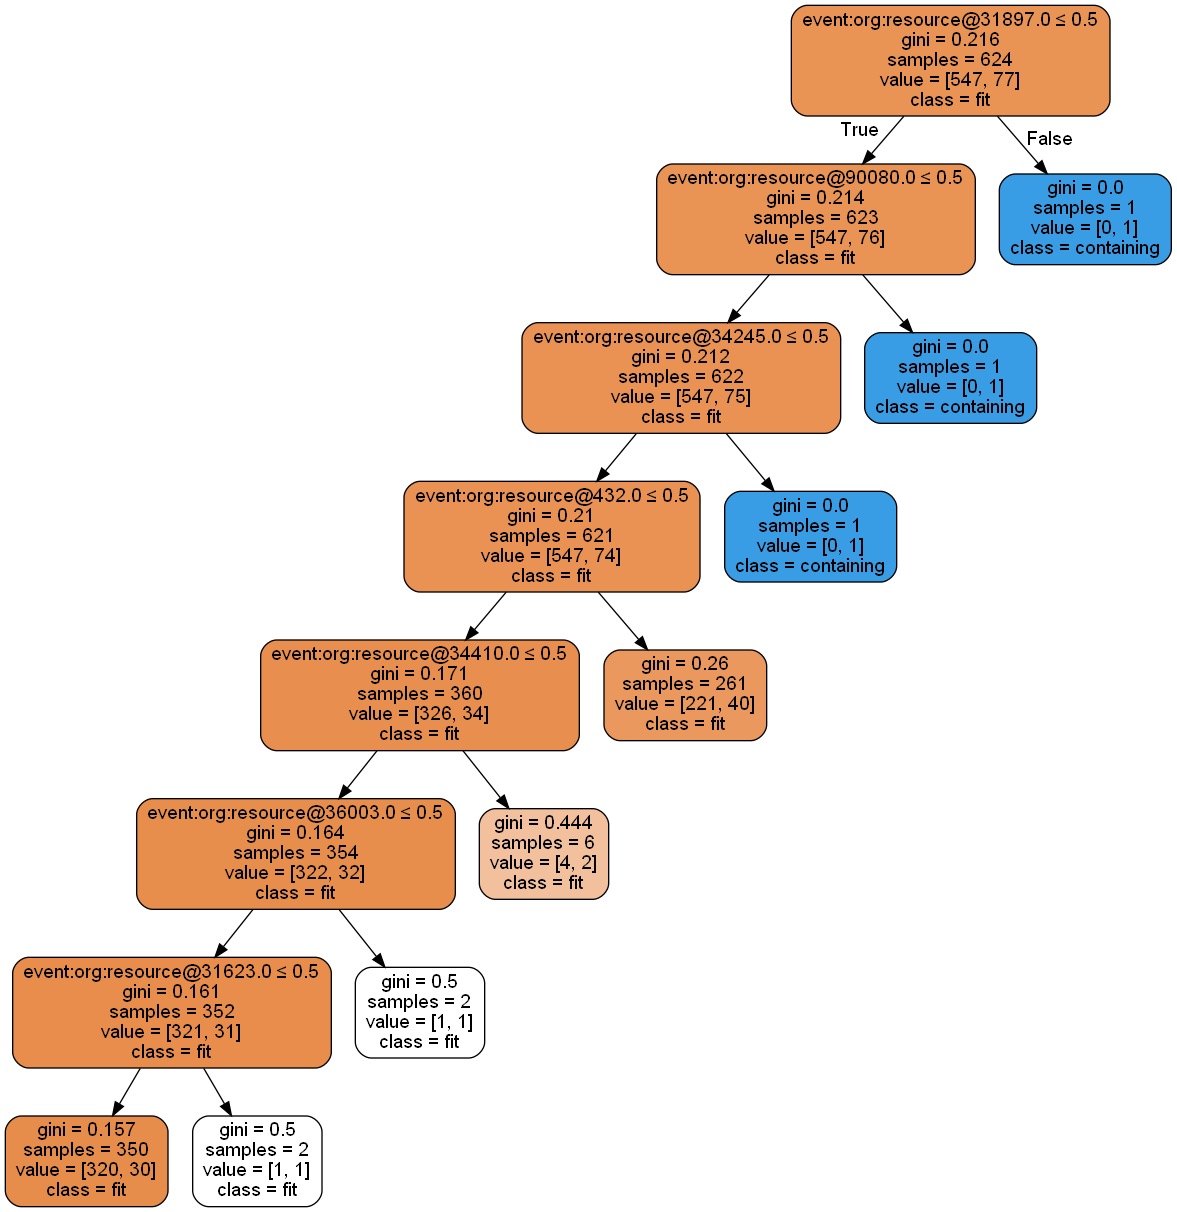

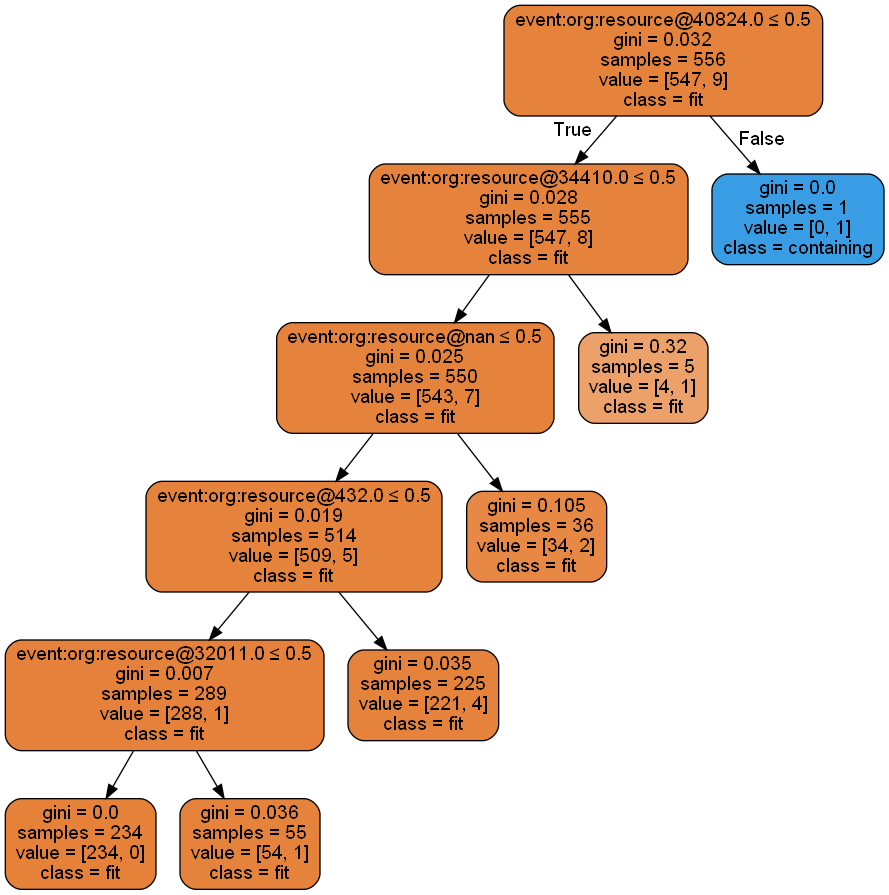

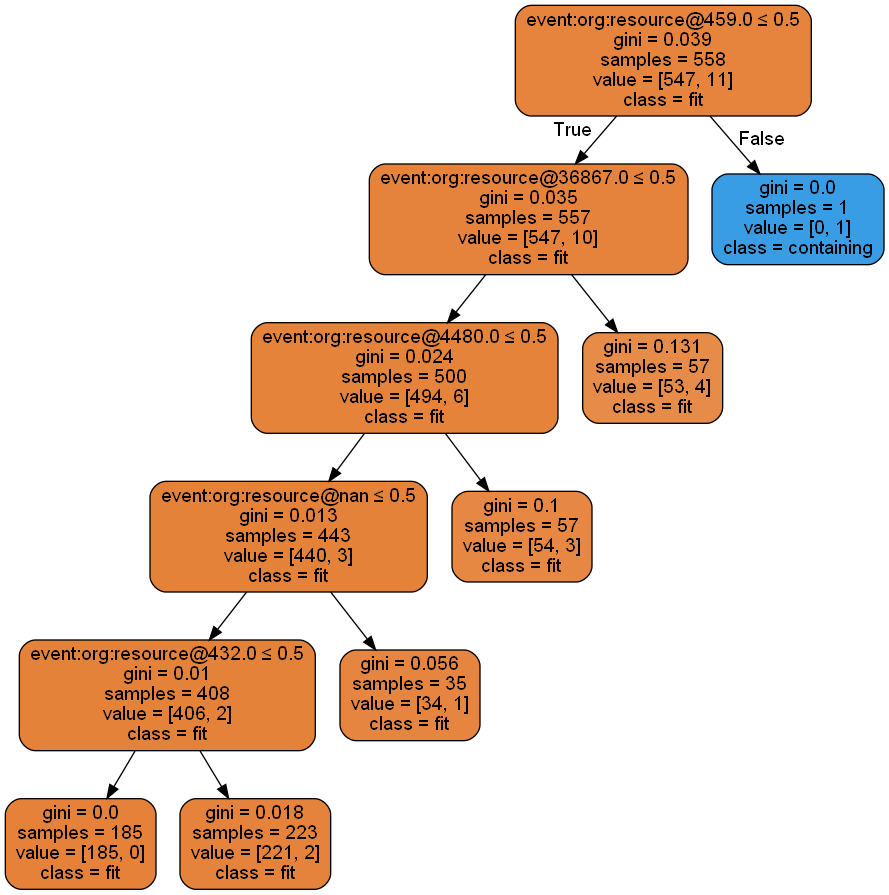

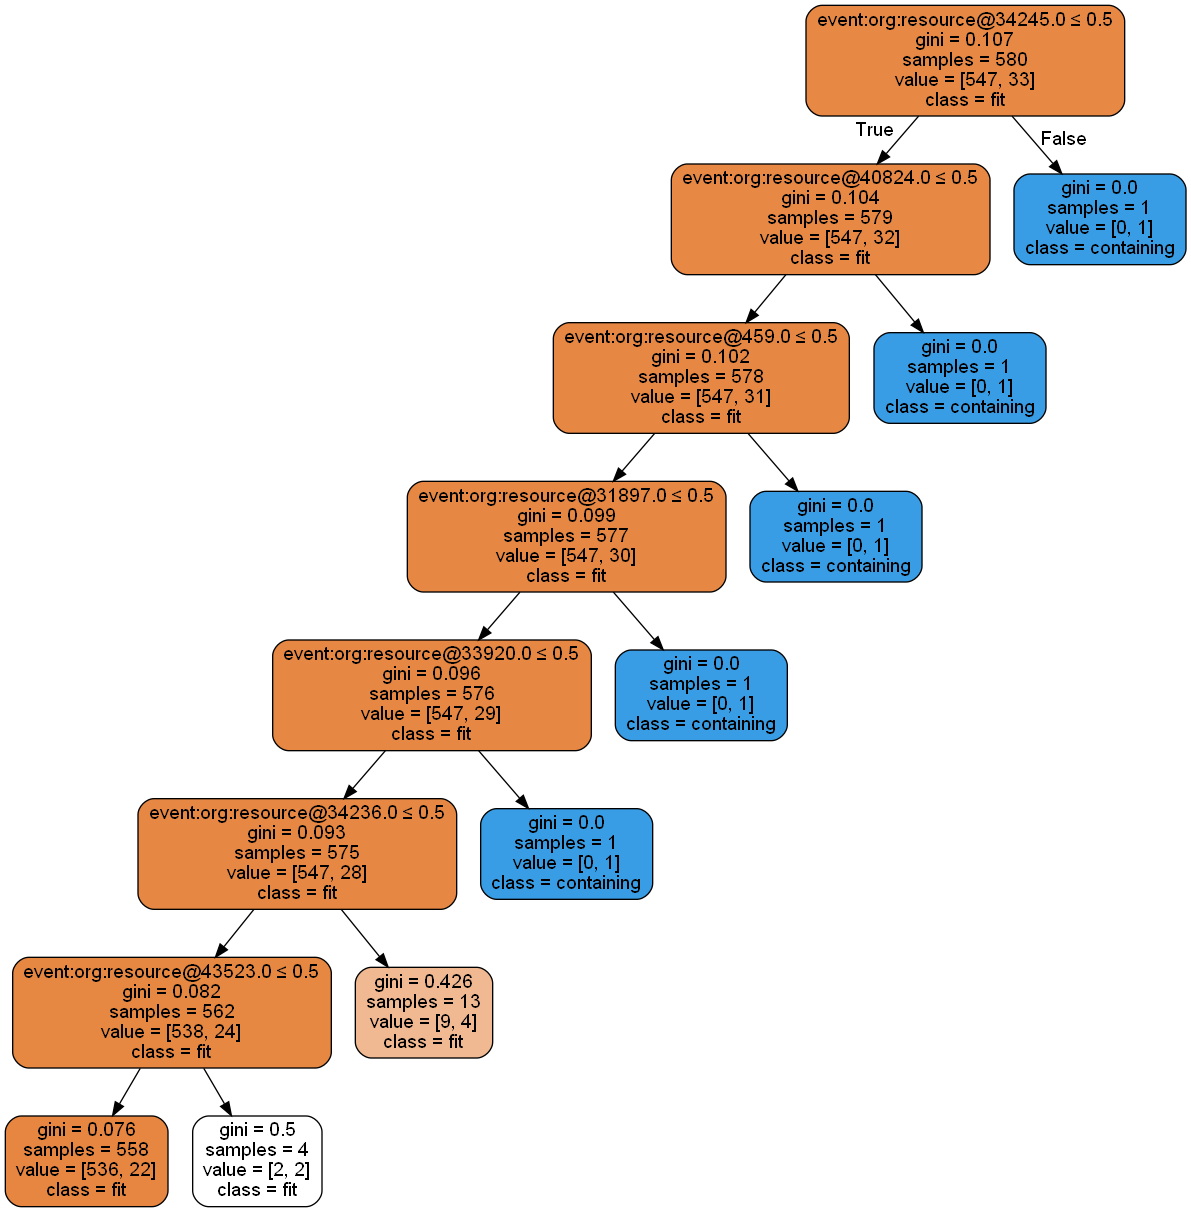

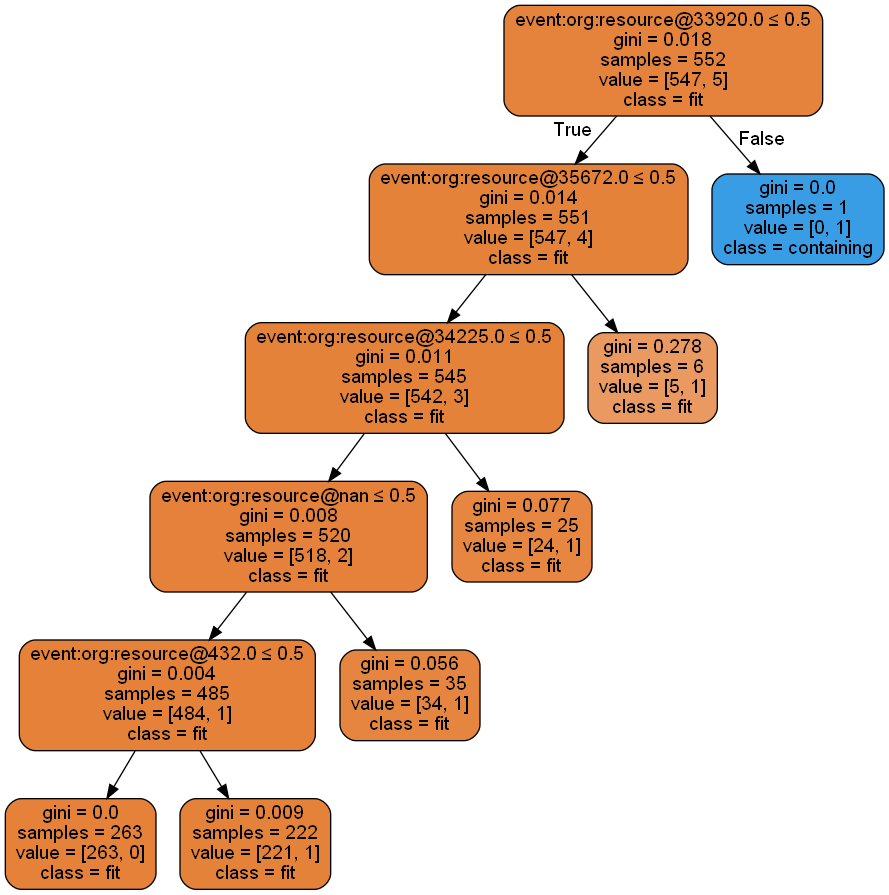

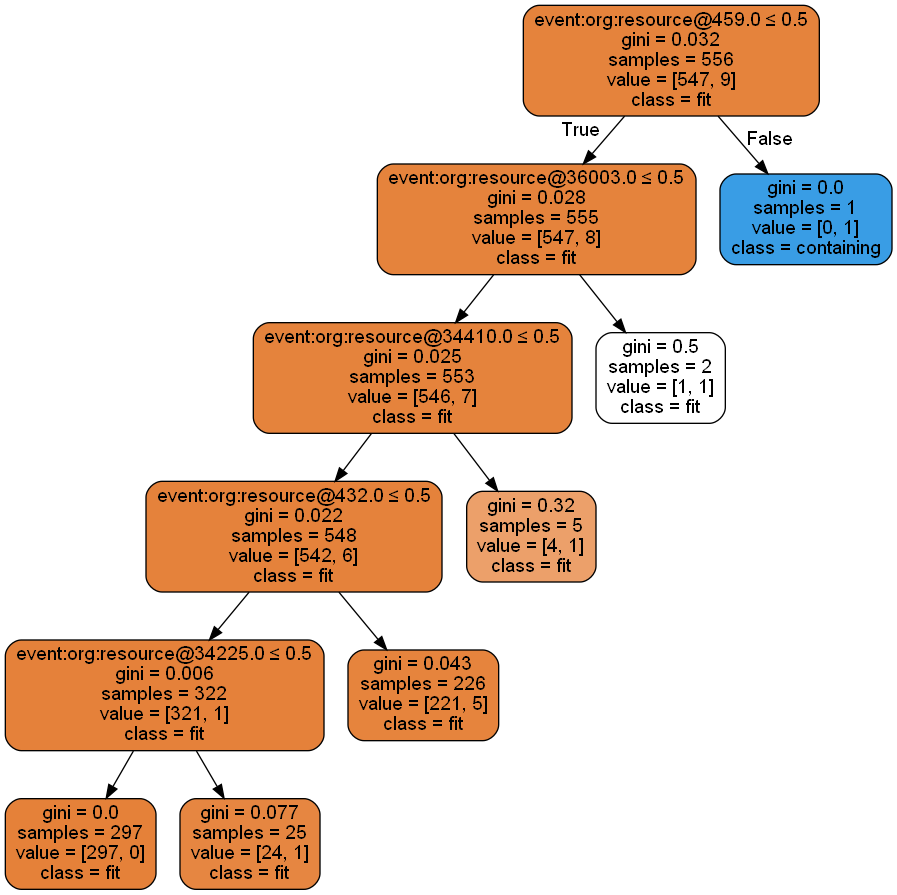

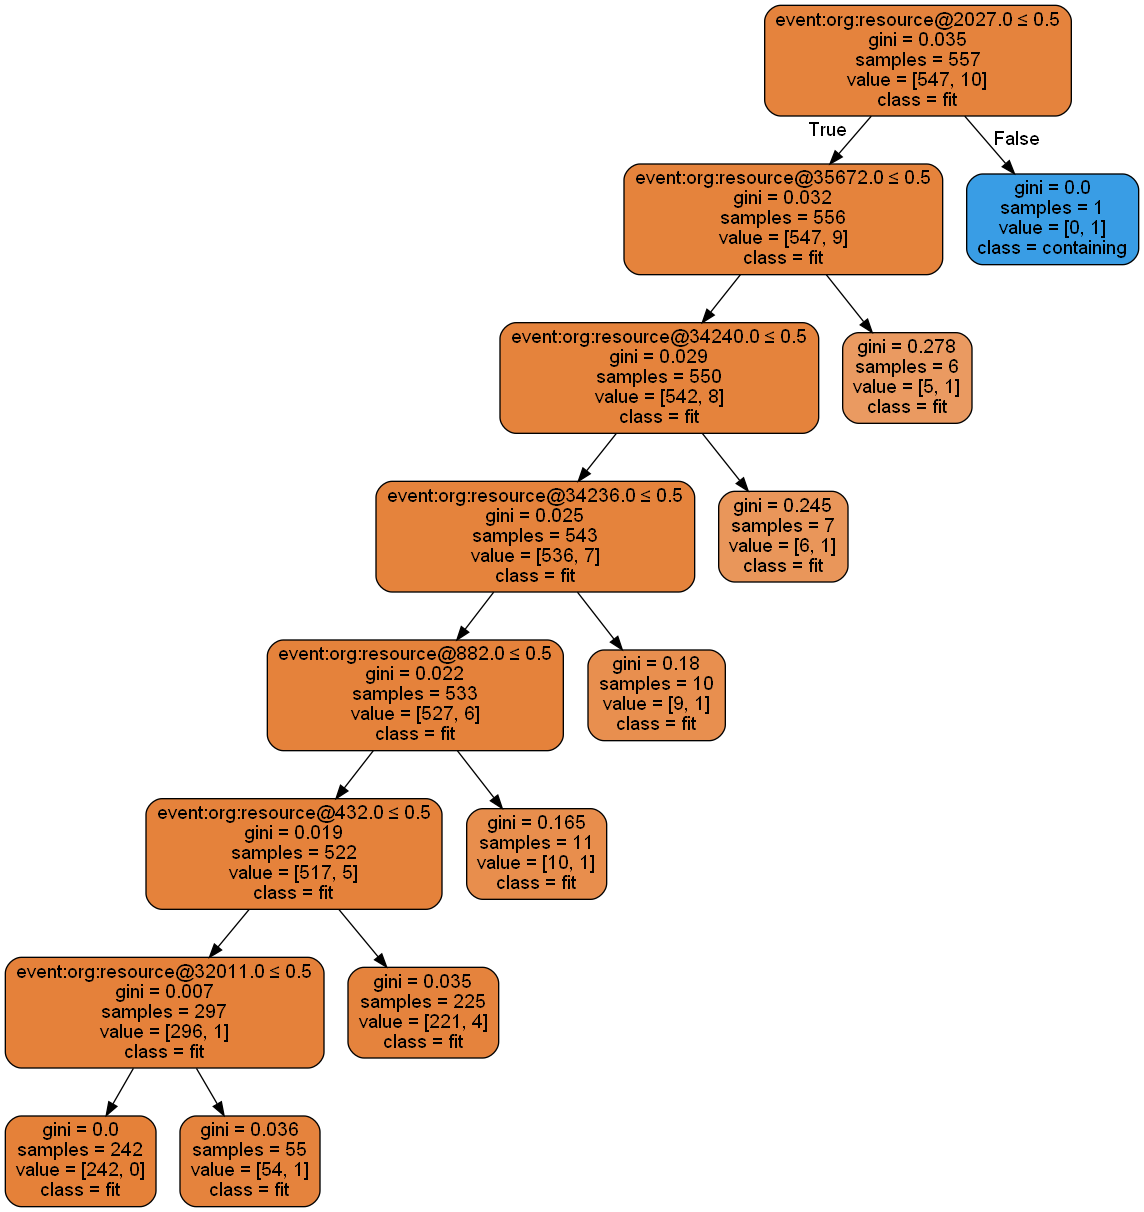

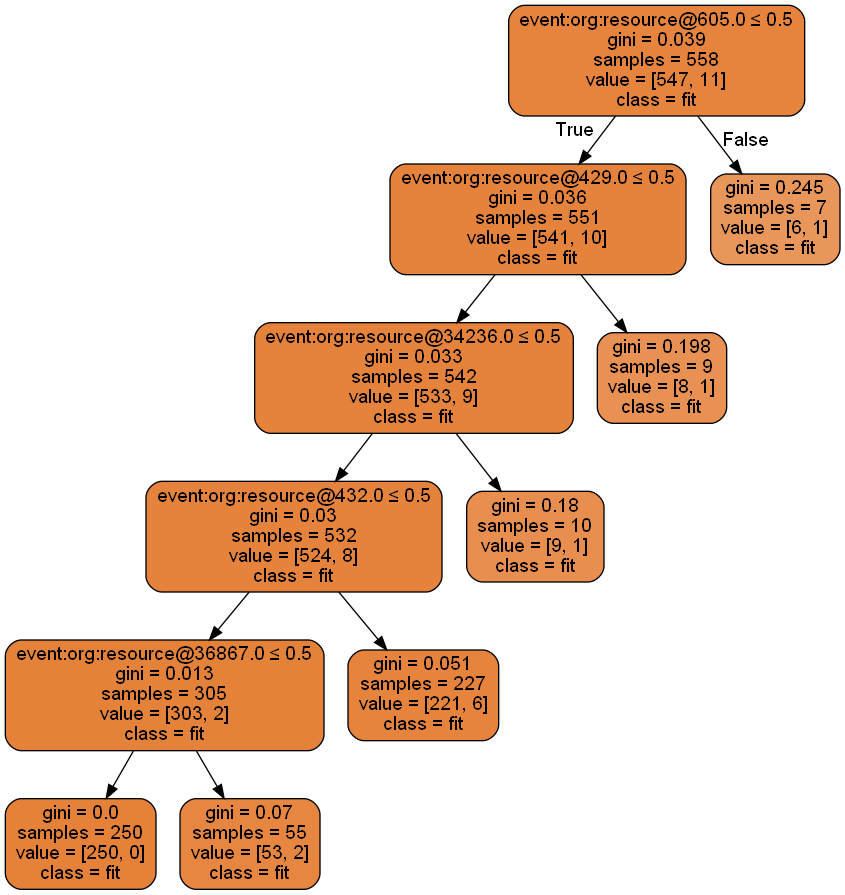

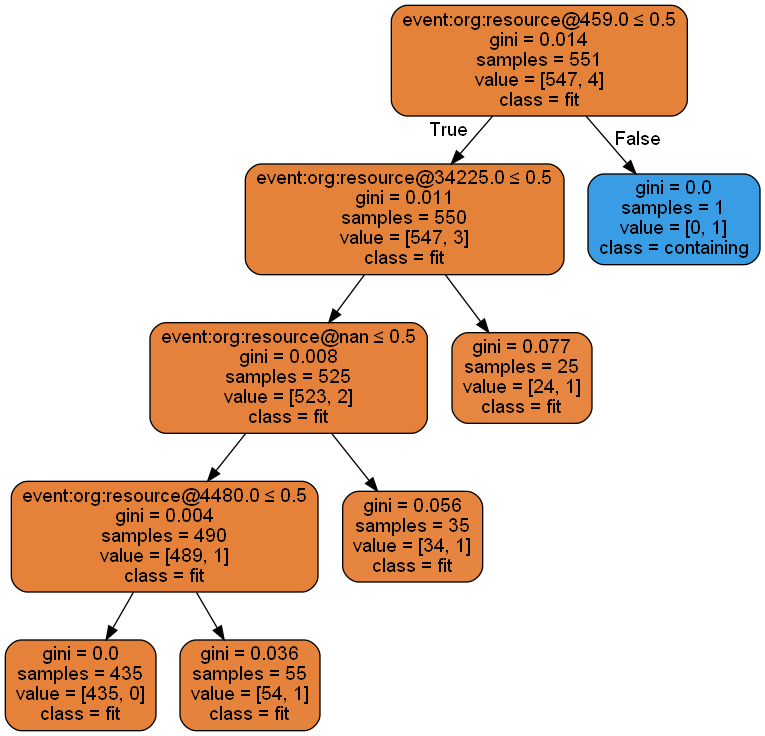

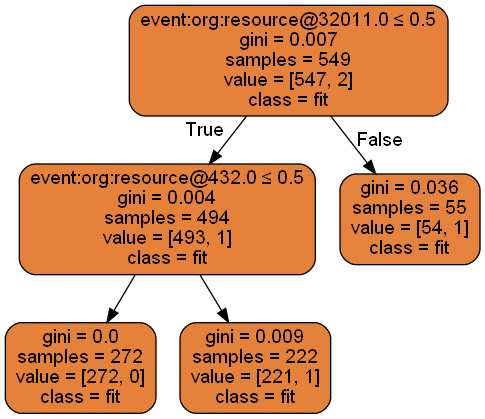

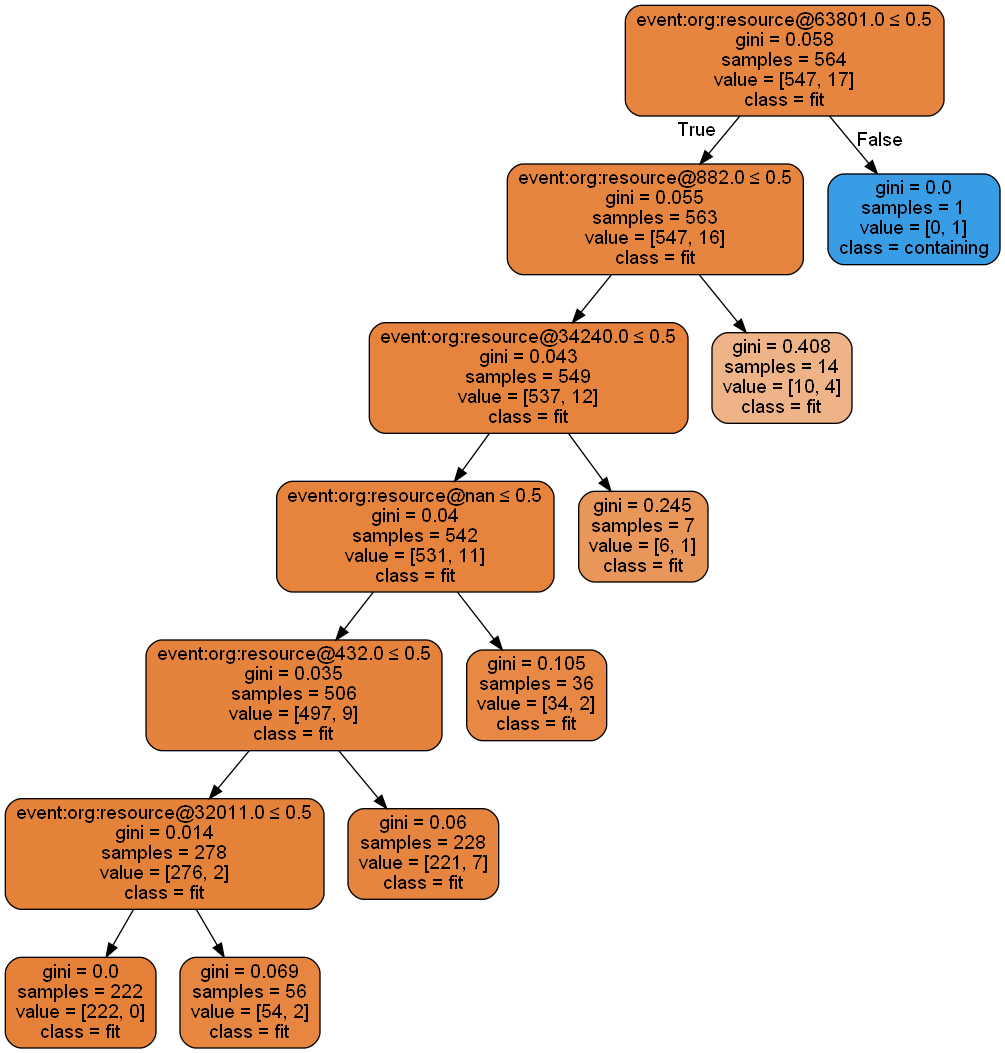

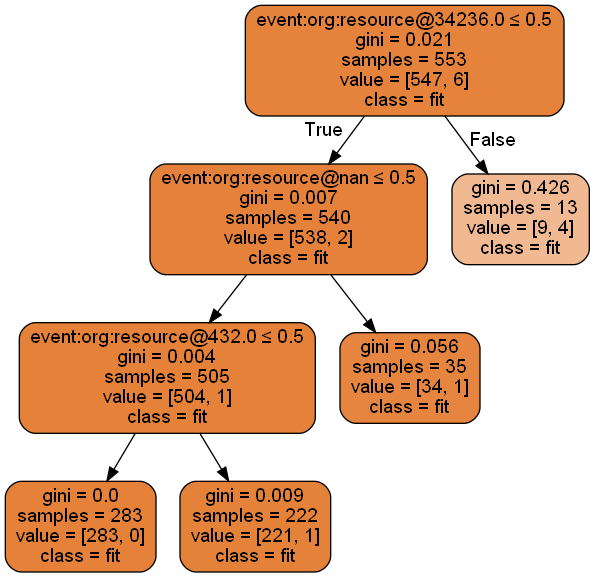

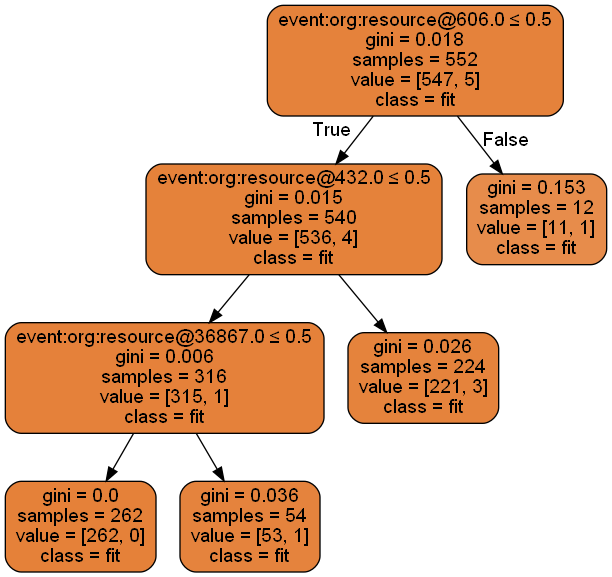

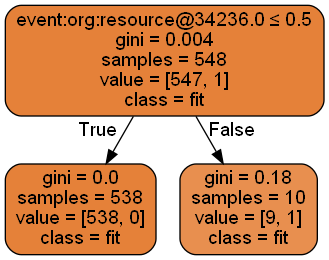

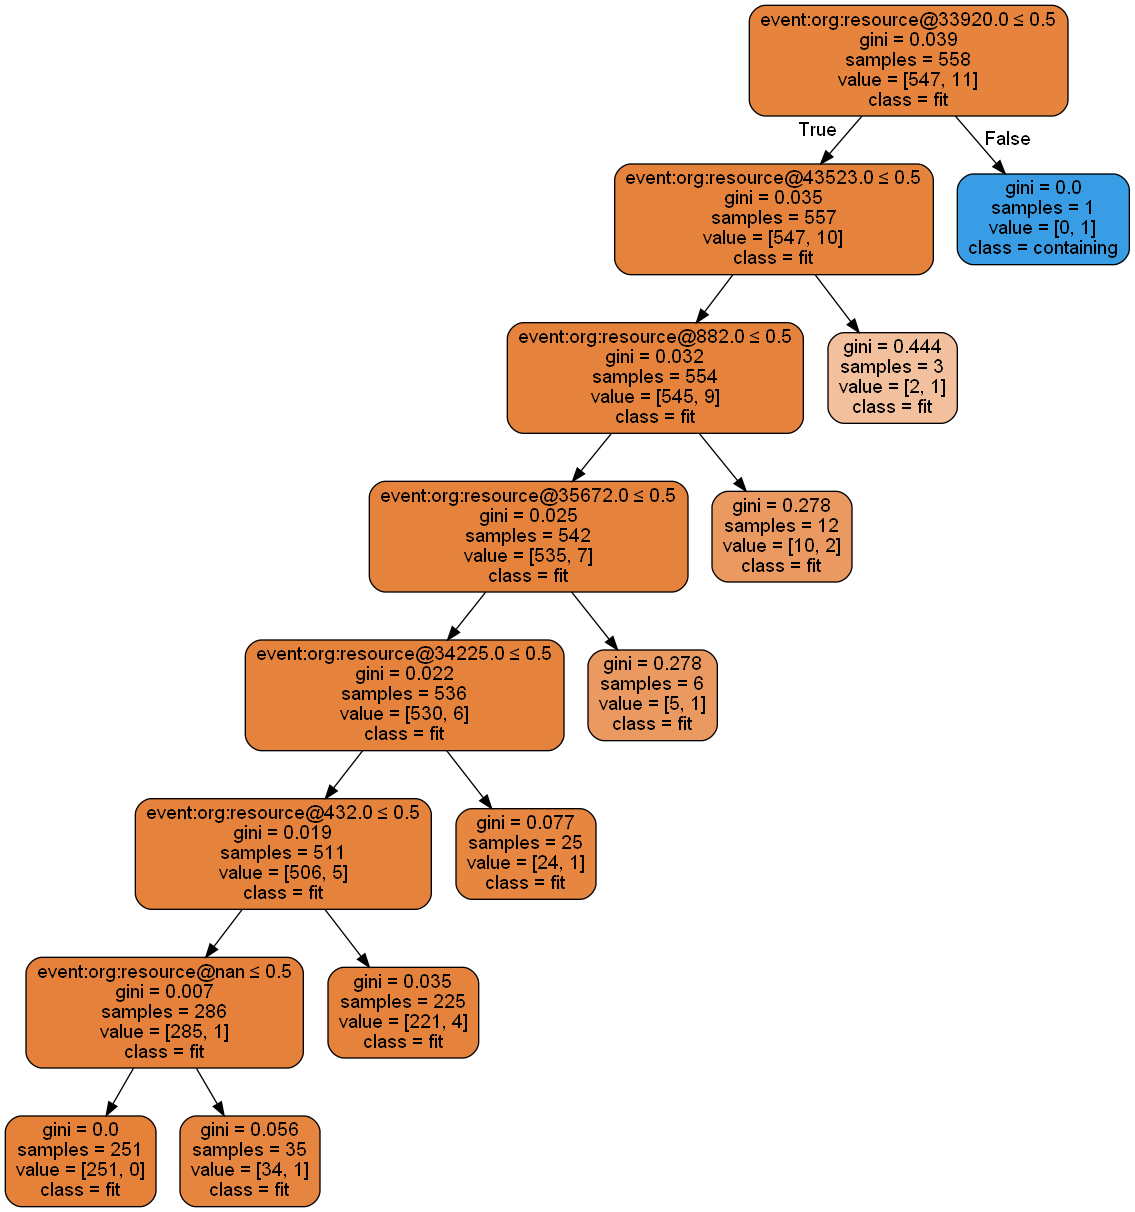

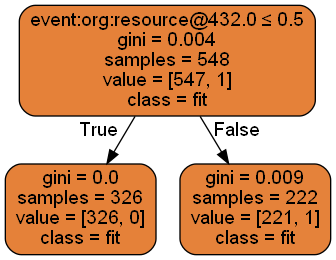

In [38]:
from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
act_root_cause = root_cause_analysis.diagnose_from_notexisting_activities(elog, unwanted_activities,
                                                                          parameters=parameters)

from pm4py.visualization.decisiontree import visualizer as dt_vis
for act in act_root_cause:
    clf = act_root_cause[act]["clf"]
    feature_names = act_root_cause[act]["feature_names"]
    classes = act_root_cause[act]["classes"]
    # visualization could be called
    gviz = dt_vis.apply(clf, feature_names, classes)
    dt_vis.view(gviz)

In [40]:
elog2 = pm.read_xes("teste.xes")

parsing log, completed traces ::   0%|          | 0/712 [00:00<?, ?it/s]

In [41]:
elog2

[{'attributes': {'concept:name': '100387160.0'}, 'events': [{'org:resource': 532.0, 'concept:name': 'Cirurgia Primária', 'time:timestamp': datetime.datetime(2021, 11, 19, 0, 0, tzinfo=datetime.timezone.utc)}, '..', {'org:resource': 532.0, 'concept:name': 'Consulta Ortopedia', 'time:timestamp': datetime.datetime(2021, 12, 3, 0, 0, tzinfo=datetime.timezone.utc)}]}, '....', {'attributes': {'concept:name': '99504.0'}, 'events': [{'org:resource': 31185.0, 'concept:name': 'Consulta Anestesia', 'time:timestamp': datetime.datetime(2019, 1, 11, 0, 0, tzinfo=datetime.timezone.utc)}, '..', {'org:resource': 432.0, 'concept:name': 'Consulta Ortopedia', 'time:timestamp': datetime.datetime(2020, 11, 23, 0, 0, tzinfo=datetime.timezone.utc)}]}]